In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from featexp import get_univariate_plots, get_trend_stats
import warnings
import xgboost as xgb
warnings.filterwarnings("ignore")
%matplotlib inline

# Preprocessing

### Creating Modelling Datasets

In [25]:
def write_model_dataset(chosen):
    raw_df = pd.read_csv("inputs/BlackFriday.csv")
    modeldf = raw_df.rename(columns =   {'User_ID' : 'u_id',
                                'Product_ID' : 'p_id',
                                'Gender' : 'gender',
                                'Age' : 'age',
                                'Occupation' : 'occ',
                                'City_Category' : 'city',
                                'Stay_In_Current_City_Years' : 'years_in_city',
                                'Marital_Status' : 'married',
                                'Product_Category_1' : 'p_cat_1',
                                'Product_Category_2' : 'p_cat_2',
                                'Product_Category_3' : 'p_cat_3',
                                'Purchase' : 'pur'})
    file_name = ""
    cols = np.asarray(modeldf.columns)
    
    # normalize user_id and prod_id, impute 0 into NaN p_cat
    modeldf['u_id'] = modeldf['u_id'] - 1000000
    modeldf['p_id'] = modeldf['p_id'].replace('[A-Za-z]', '', regex = True)
    modeldf['p_id'] = pd.to_numeric(modeldf.p_id, errors='coerce')
    modeldf['p_cat_2'].fillna(0, inplace = True)
    modeldf['p_cat_3'].fillna(0, inplace = True)
    modeldf['p_cat_2'] = modeldf['p_cat_2'].astype(int)
    modeldf['p_cat_3'] = modeldf['p_cat_3'].astype(int)
    
    # Creates dataset with imputed 0s and labelvector on age
    if chosen == 0:
        # uncomment these 2 lines to replace 0's with mean
        #modeldf['p_cat_2'].replace(0, modeldf['p_cat_2'].mean(), inplace = True)
        #modeldf['p_cat_3'].replace(0, modeldf['p_cat_3'].mean(), inplace = True)
        label_features = ['gender', 'age', 'years_in_city', 'city']
        for feature in label_features:
            ranges = pd.unique(pd.Series(modeldf[feature]))
            ranges.sort()
            mapped = [x for x in range(len(ranges))]
            modeldf[feature] = modeldf[feature].map(dict(zip(ranges, mapped)))
        file_name = "minimal_preprocess.csv"
    elif chosen == 1:
        # Creates dataset with one hot vectors on occ, city, p_cats
        one_hot_features = ['occ', 'city', 'p_cat_1', 'p_cat_2', 'p_cat_3']
        for feature in one_hot_features:
            if feature in cols:
                ranges = pd.unique(pd.Series(modeldf[feature]))
                ranges.sort()
                mapped = [feature + '_' + str(x) for x in ranges]
                modeldf[feature] = modeldf[feature].map(dict(zip(ranges, mapped)))
                one_hot = pd.get_dummies(modeldf[feature])
                modeldf = modeldf.drop(feature, axis = 1)
                modeldf = modeldf.join(one_hot)

        label_features = ['gender', 'age', 'years_in_city']

        for feature in label_features:
            ranges = pd.unique(pd.Series(modeldf[feature]))
            ranges.sort()
            mapped = [x for x in range(len(ranges))]
            modeldf[feature] = modeldf[feature].map(dict(zip(ranges, mapped)))
        file_name = "some_one_hot.csv"
    elif chosen == 2:
        # creates dataset with one hot vectors on all categorical features
        cat_features = ['age', 'occ', 'city', 'p_cat_1', 'p_cat_2', 'p_cat_3', 'years_in_city']
        for cat in cat_features:
            if cat in cols:
                ranges = pd.unique(pd.Series(modeldf[cat]))
                ranges.sort()
                mapped = [cat + '_' + str(x) for x in range(len(ranges))]
                modeldf[cat] = modeldf[cat].map(dict(zip(ranges, mapped)))
                one_hot = pd.get_dummies(modeldf[cat])
                modeldf = modeldf.drop(cat, axis = 1)
                modeldf = modeldf.join(one_hot)

        label_features = ['gender']

        for feature in label_features:
            ranges = pd.unique(pd.Series(modeldf[feature]))
            ranges.sort()
            mapped = [str(x) for x in range(len(ranges))]
            modeldf[feature] = modeldf[feature].map(dict(zip(ranges, mapped)))
        file_name = "all_one_hot.csv"

    if len(file_name) != 0:
        modeldf.to_csv("inputs/" + file_name , encoding='utf-8', index = False)
        
    return modeldf

In [26]:
# minimal_preprocess = 0
# some_one_hot = 1
# all_one_hot = 2

write_model_dataset(0).head()

u_id    p_id  gender  age  occ  city  years_in_city  married  p_cat_1  \
0     1   69042       0    0   10     0              2        0        3   
1     1  248942       0    0   10     0              2        0        1   
2     1   87842       0    0   10     0              2        0       12   
3     1   85442       0    0   10     0              2        0       12   
4     2  285442       1    6   16     2              4        0        8   

   p_cat_2  p_cat_3    pur  
0        0        0   8370  
1        6       14  15200  
2        0        0   1422  
3       14        0   1057  
4        0        0   7969

### Choose Modeling Dataset to Use

In [2]:
def read_model_dataset(chosen):
    non_features = ['u_id', 'p_id']
    demo_cols = []
    predictor = ['pur']
    file_name = ""

    if chosen == 0:
        file_name = "minimal_preprocess.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
    elif chosen == 1:
        file_name = "some_one_hot.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'occ_0', 'occ_1', 'occ_10',
               'occ_11', 'occ_12', 'occ_13', 'occ_14', 'occ_15', 'occ_16', 'occ_17',
               'occ_18', 'occ_19', 'occ_2', 'occ_20', 'occ_3', 'occ_4', 'occ_5',
               'occ_6', 'occ_7', 'occ_8', 'occ_9', 'city_A', 'city_B', 'city_C']
    elif chosen == 2:
        file_name = "all_one_hot.csv"
        demo_cols = ['gender', 'married', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4',
               'age_5', 'age_6', 'occ_0', 'occ_1', 'occ_10', 'occ_11', 'occ_12',
               'occ_13', 'occ_14', 'occ_15', 'occ_16', 'occ_17', 'occ_18', 'occ_19',
               'occ_2', 'occ_20', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_7', 'occ_8',
               'occ_9', 'city_0', 'city_1', 'city_2',
               'years_in_city_0', 'years_in_city_1', 'years_in_city_2',
               'years_in_city_3', 'years_in_city_4']
    else:
        file_name = "minimal_preprocess.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']

    modeldf = pd.read_csv("inputs/" + file_name)
    modeldf = modeldf.drop(non_features, axis = 1)
    # line below removes purchase outliers from modeldf
    # modeldf = modeldf[modeldf["pur"] < modeldf["pur"].quantile(0.99)]
    X = modeldf.drop(predictor, axis = 1)
    if chosen != 0:
        X = X.drop('p_cat_2_0', axis = 1)
        X = X.drop('p_cat_3_0', axis = 1)
    y = modeldf[predictor]
    
    return modeldf, X, y, predictor, demo_cols

In [3]:
# minimal_preprocess = 0
# some_one_hot = 1
# all_one_hot = 2
# defaults to minimal_preprocess

modeldf, X, y, predictor, demo_cols = read_model_dataset(1)
modeldf.head()

gender  age  years_in_city  married    pur  occ_0  occ_1  occ_10  occ_11  \
0       0    0              2        0   8370      0      0       1       0   
1       0    0              2        0  15200      0      0       1       0   
2       0    0              2        0   1422      0      0       1       0   
3       0    0              2        0   1057      0      0       1       0   
4       1    6              4        0   7969      0      0       0       0   

   occ_12    ...      p_cat_3_15  p_cat_3_16  p_cat_3_17  p_cat_3_18  \
0       0    ...               0           0           0           0   
1       0    ...               0           0           0           0   
2       0    ...               0           0           0           0   
3       0    ...               0           0           0           0   
4       0    ...               0           0           0           0   

   p_cat_3_3  p_cat_3_4  p_cat_3_5  p_cat_3_6  p_cat_3_8  p_cat_3_9  
0          0          0          0          0          0          0  
1          0          0          0          0          0          0  
2          0          0          0          0          0          0  
3          0          0          0          0          0          0  
4          0          0          0          0          0          0  

[5 rows x 81 columns]

# Exploration

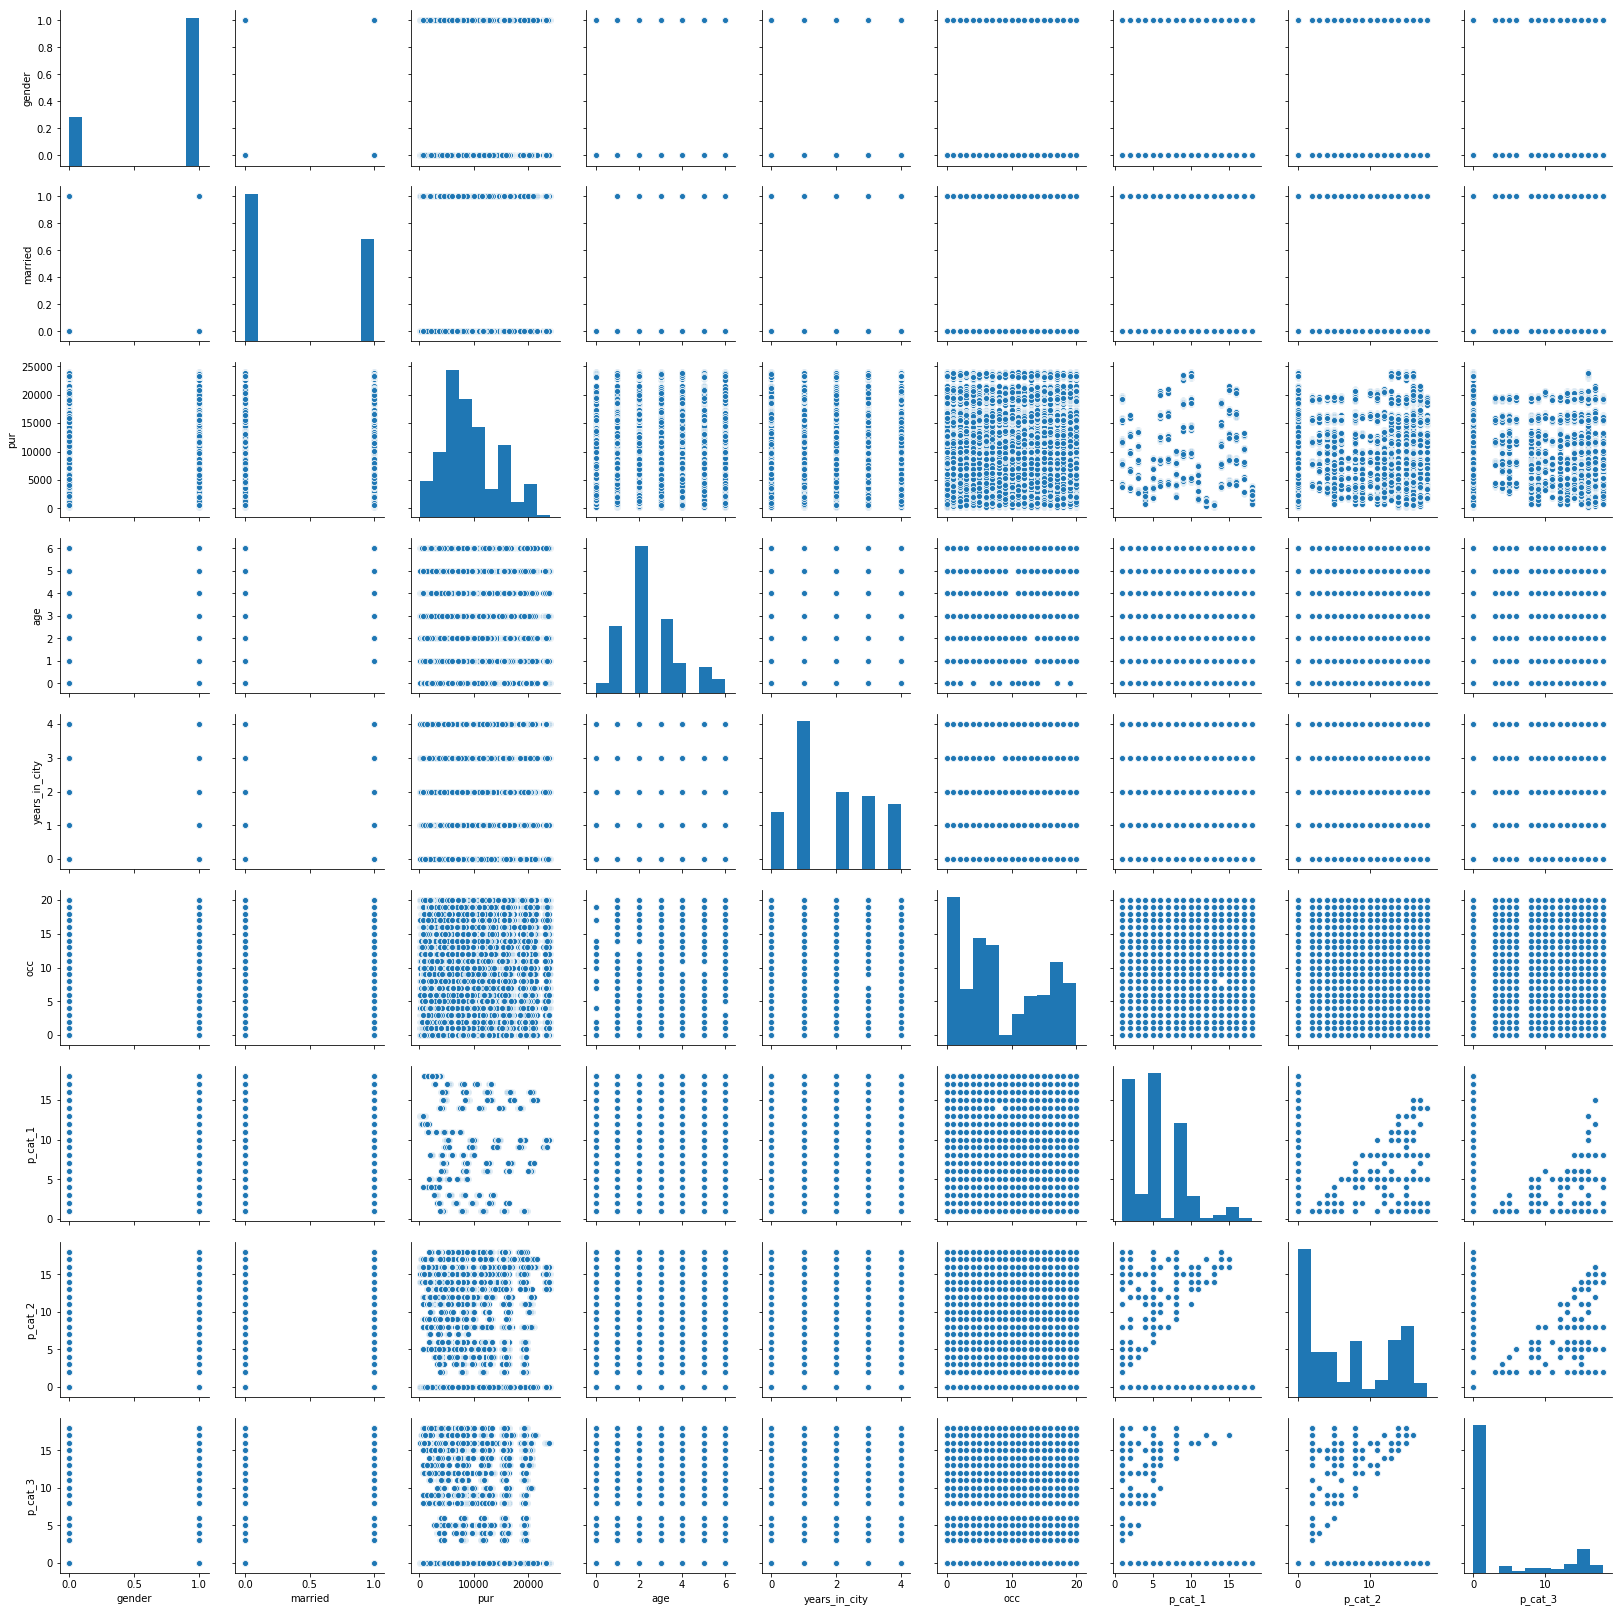

In [41]:
pairs = ['gender', 'married', 'pur', 'age', 'years_in_city', 'occ', 'p_cat_1', 'p_cat_2', 'p_cat_3']
sns.pairplot(modeldf[pairs])

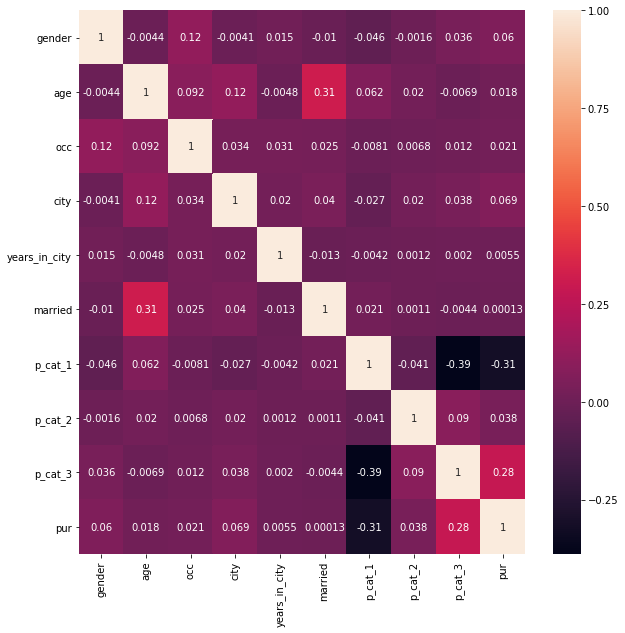

In [5]:
fig, axes = plt.subplots(1, 1, figsize = (10, 10))
sns.heatmap(modeldf.corr(), annot = True, ax = axes)

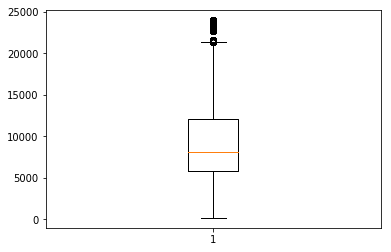

In [89]:
plt.boxplot(modeldf['pur'])
plt.show()

In [10]:
modeldf.describe()

gender            age           occ           city  \
count  537577.000000  537577.000000  537577.00000  537577.000000   
mean        0.754087       2.494755       8.08271       1.040567   
std         0.430627       1.352583       6.52412       0.759627   
min         0.000000       0.000000       0.00000       0.000000   
25%         1.000000       2.000000       2.00000       0.000000   
50%         1.000000       2.000000       7.00000       1.000000   
75%         1.000000       3.000000      14.00000       2.000000   
max         1.000000       6.000000      20.00000       2.000000   

       years_in_city        married        p_cat_1        p_cat_2  \
count  537577.000000  537577.000000  537577.000000  537577.000000   
mean        1.859458       0.408797       5.295546       9.842144   
std         1.289828       0.491612       3.750701       4.223872   
min         0.000000       0.000000       1.000000       2.000000   
25%         1.000000       0.000000       1.000000       8.000000   
50%         2.000000       0.000000       5.000000       9.842144   
75%         3.000000       1.000000       8.000000      14.000000   
max         4.000000       1.000000      18.000000      18.000000   

             p_cat_3            pur  
count  537577.000000  537577.000000  
mean       12.669840    9333.859853  
std         2.279938    4981.022133  
min         3.000000     185.000000  
25%        12.669840    5866.000000  
50%        12.669840    8062.000000  
75%        12.669840   12073.000000  
max        18.000000   23961.000000

In [66]:
# splits datasets based on demographics specified
cats = ["p_id"]
cluster_splits = cats


temp = [modeldf]
first = True
for split in cluster_splits:
    other_temp = []
    for other in temp:
        other_temp.append([other[other[split] == x] for x in range(min(other[split]), max(other[split]) + 1)])
    if first:
        temp = other_temp[0]
        first = False
    else:
        temp = []
        for other in other_temp:
            for some_other in other:
                if not some_other.empty:
                    temp.append(some_other)

custom_clusters = sorted(temp, key=len)

In [100]:
num_top = 20
top_prods = modeldf.drop_duplicates().p_id.value_counts()[:num_top].to_frame()


p_id
265242  1858
110742  1591
25442   1586
112142  1539
57642   1430
184942  1424
46742   1417
58042   1396
59442   1384
145042  1384
237542  1374
255842  1354
117942  1346
110942  1336
10742   1331
110842  1260
220442  1253
51442   1233
102642  1228
117442  1227

In [172]:
top5 = [265242,110742,25442,112142,57642]

topdfs = [modeldf.loc[modeldf['p_id'] == x] for x in top5]

KeyError: 'p_id'

                                           Plots for gender                                           


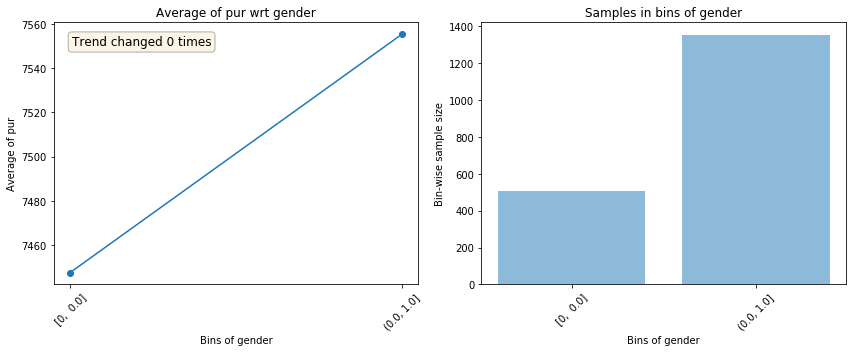

--------------------------------------------------------------------------------------------------------------


                                            Plots for age                                             


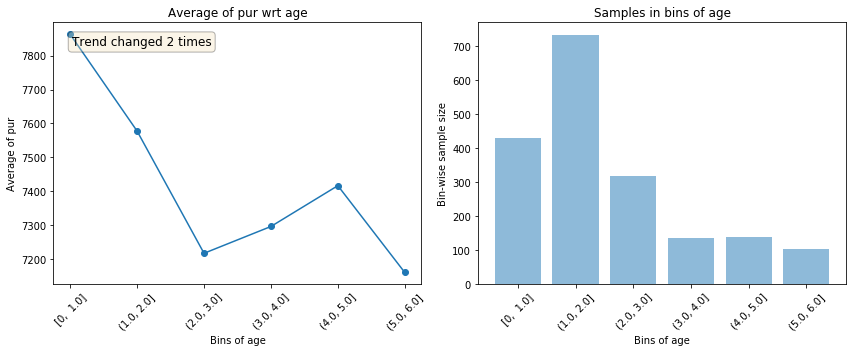

--------------------------------------------------------------------------------------------------------------


                                            Plots for occ                                             


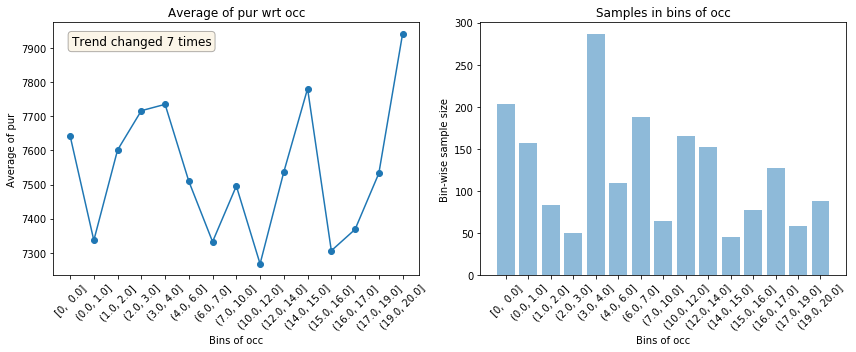

--------------------------------------------------------------------------------------------------------------


                                            Plots for city                                            


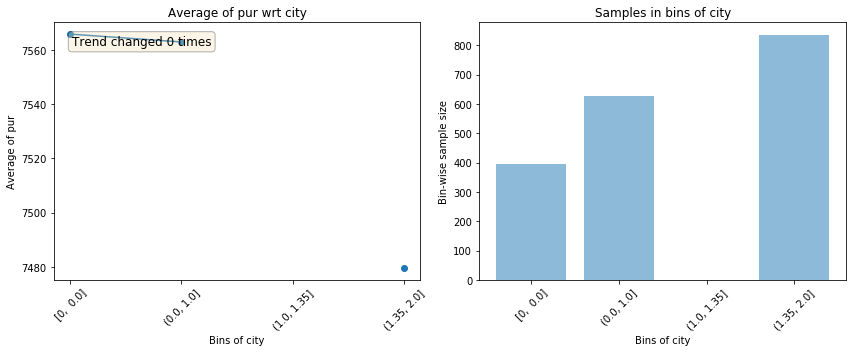

--------------------------------------------------------------------------------------------------------------


                                       Plots for years_in_city                                        


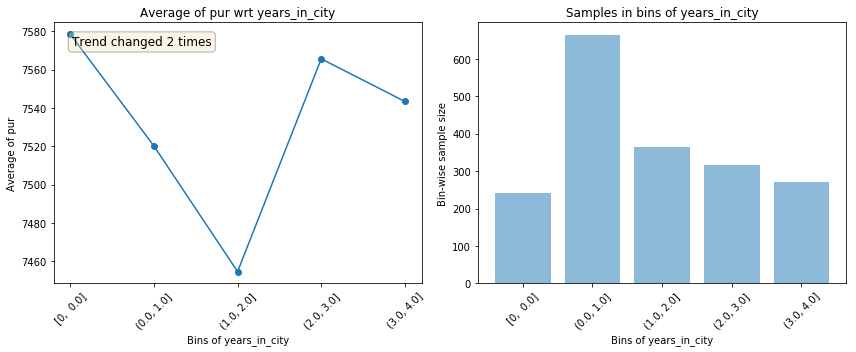

--------------------------------------------------------------------------------------------------------------


                                          Plots for married                                           


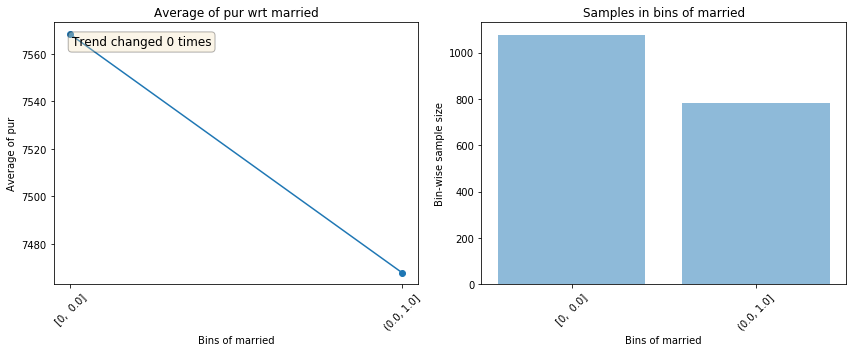

--------------------------------------------------------------------------------------------------------------




In [113]:
get_univariate_plots(data=temp, target_col='pur', 
                     features_list= temp.drop(['u_id', 'p_id', 'pur', 'p_cat_1', 'p_cat_2', 'p_cat_3'], axis = 1).columns, bins=20)

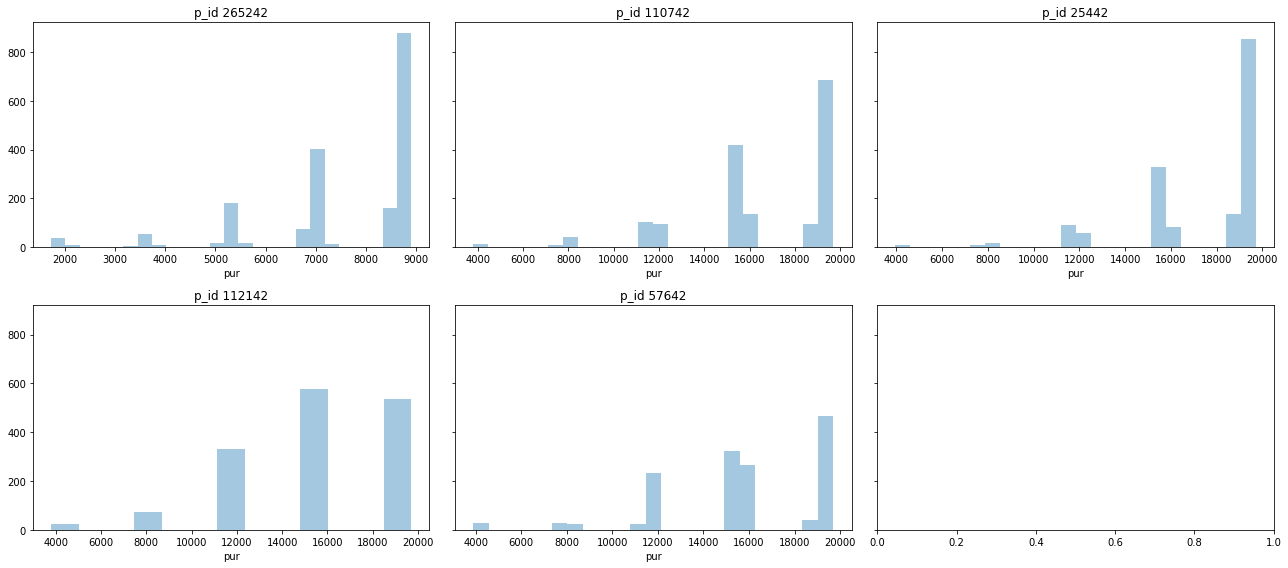

In [87]:
n_cols = 3
n_rows = len(topdfs)//n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize = (18,4 * n_rows), sharey=True)
for i, df in enumerate(topdfs):
    axs[i//n_cols, i%n_cols].set_title("p_id %d" % top5[i])
    sns.distplot(df['pur'], kde = False, ax = axs[i//n_cols, i%n_cols])
plt.tight_layout()

<BarContainer object of 235 artists>

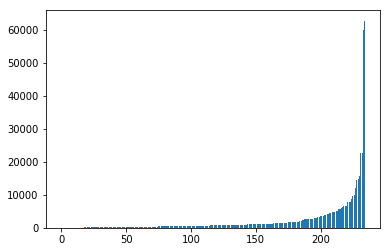

In [55]:
plt.bar(range(len(custom_clusters)), [len(x) for x in custom_clusters])

In [5]:
lower = .80
upper = 1

trimmed_modeldf = pd.concat(custom_clusters[int(len(custom_clusters) * lower) : int(len(custom_clusters) * upper - 1)])

In [6]:
trimmed_modeldf

gender  age  occ  city  years_in_city  married  p_cat_1  p_cat_2  \
299          0    0   10     2              2        0       15       16   
354          1    2    2     1              3        0       15       16   
584          1    1   12     2              2        0       15       16   
656          0    4    3     2              1        1       15       16   
1365         0    2    4     0              0        0       15       16   
1511         1    3   16     1              0        0       15       16   
1979         1    6   13     2              1        0       15       16   
3069         1    2   12     1              0        0       15       16   
3111         1    2    0     2              4        0       15       16   
3799         1    5    2     2              2        1       15       16   
4023         0    1    0     2              2        0       15       16   
4221         1    1    4     0              1        0       15       16   
4513         1    2   14     0              3        0       15       16   
4780         1    1   19     1              1        0       15       16   
5165         1    3    0     0              3        1       15       16   
5270         1    2   12     1              4        1       15       16   
5301         1    1   20     0              4        1       15       16   
5461         1    4   20     0              1        0       15       16   
5472         1    4   20     0              1        0       15       16   
5770         0    3    6     2              0        0       15       16   
6012         1    3   14     2              4        1       15       16   
6215         1    2    8     2              4        1       15       16   
6845         1    0   10     2              1        0       15       16   
7745         1    3   12     1              0        0       15       16   
7788         0    5    7     2              1        1       15       16   
7790         0    5    7     2              1        1       15       16   
7791         1    2    0     2              1        1       15       16   
7818         1    3   17     2              0        0       15       16   
7971         1    0   10     1              1        0       15       16   
8049         1    1    4     0              2        0       15       16   
...        ...  ...  ...   ...            ...      ...      ...      ...   
537221       0    3   15     2              2        0        8        0   
537225       0    3   15     2              2        0        8        0   
537237       1    2    7     1              3        1        8        0   
537245       1    2    7     1              3        1        8        0   
537246       1    2    7     1              3        1        8        0   
537247       1    2    7     1              3        1        8        0   
537256       1    3    1     1              2        1        8        0   
537257       1    3    1     1              2        1        8        0   
537260       1    3    1     1              2        1        8        0   
537284       0    4   17     1              2        1        8        0   
537288       0    2    7     2              3        0        8        0   
537296       1    6    7     2              3        1        8        0   
537334       1    1   20     2              1        0        8        0   
537338       0    1    0     2              0        1        8        0   
537346       0    1    0     2              0        1        8        0   
537347       1    2   14     1              4        1        8        0   
537354       1    0    0     2              4        0        8        0   
537368       1    2    0     1              3        0        8        0   
537370       1    2    0     1              3        0        8        0   
537382       1    5    1     0              1        1        8        0   
537383       1    5    1     0              1        1  

In [7]:
# splits datasets based on demographics specified
cluster_splits = ['gender', 'age', 'married']

temp = [trimmed_modeldf]
first = True
for split in cluster_splits:
    other_temp = []
    for other in temp:
        other_temp.append([other[other[split] == x] for x in range(min(other[split]), max(other[split]) + 1)])
    if first:
        temp = other_temp[0]
        first = False
    else:
        temp = []
        for other in other_temp:
            for some_other in other:
                if not some_other.empty:
                    temp.append(some_other)

custom_clusters = sorted(temp, key=len)

C:\Users\mrchr\Miniconda3\envs\tensorflow_gpuenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


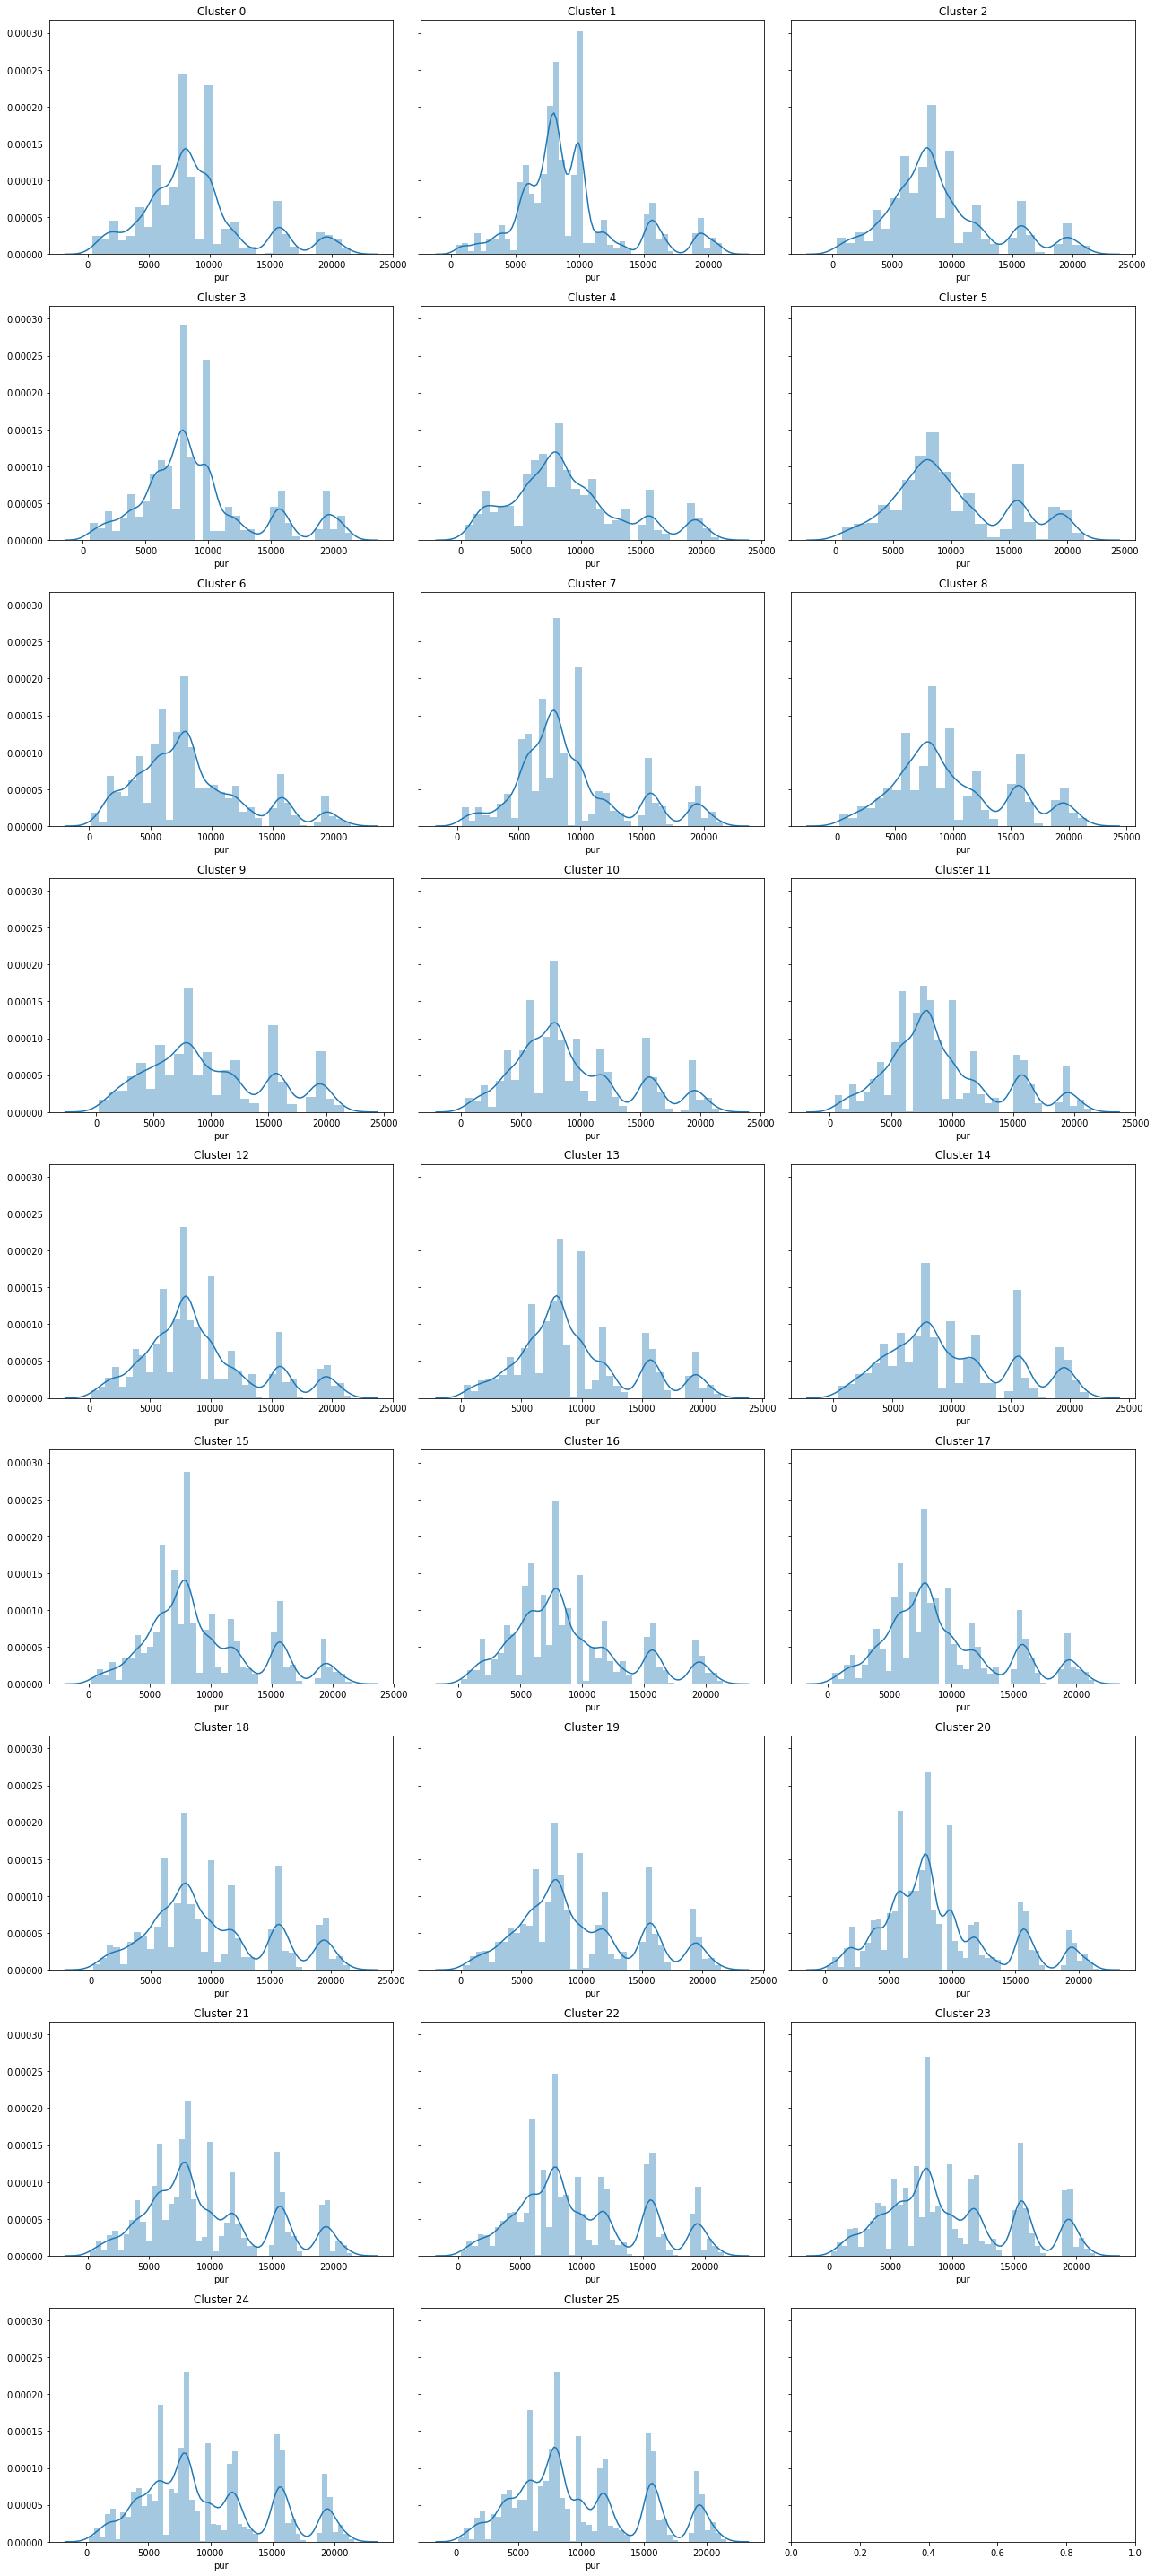

In [8]:
fig, axs = plt.subplots(len(custom_clusters)//3 + 1, 3, figsize = (18,40), sharey=True)
for i, cluster in enumerate(custom_clusters):
    axs[i//3, i%3].set_title("Cluster %d" % i)
    sns.distplot(cluster['pur'], ax = axs[i//3, i%3])
plt.tight_layout()

In [ ]:
# Creates dataset with one hot vectors except on age
one_hot_features = ['occ', 'city', 'p_cat_1', 'p_cat_2', 'p_cat_3']
for feature in one_hot_features:
    if feature in cols:
        ranges = pd.unique(pd.Series(trimmed_modeldf[feature]))
        ranges.sort()
        mapped = [feature + '_' + str(x) for x in range(len(ranges))]
        trimmed_modeldf[feature] = trimmed_modeldf[feature].map(dict(zip(ranges, mapped)))
        one_hot = pd.get_dummies(trimmed_modeldf[feature])
        trimmed_modeldf = trimmed_modeldf.drop(feature, axis = 1)
        trimmed_modeldf = trimmed_modeldf.join(one_hot)

label_features = ['gender', 'age', 'years_in_city']

for feature in label_features:
    ranges = pd.unique(pd.Series(df[feature]))
    ranges.sort()
    mapped = [x for x in range(len(ranges))]
    trimmed_modeldf[feature] = trimmed_modeldf[feature].map(dict(zip(ranges, mapped)))

In [9]:
# splits datasets based on demographics specified
cluster_splits = ['gender', 'age', 'married', 'city']

temp = [modeldf]
first = True
for split in cluster_splits:
    other_temp = []
    for other in temp:
        other_temp.append([other[other[split] == x] for x in range(min(other[split]), max(other[split]) + 1)])
    if first:
        temp = other_temp[0]
        first = False
    else:
        temp = []
        for other in other_temp:
            for some_other in other:
                if not some_other.empty:
                    temp.append(some_other)

custom_clusters = sorted(temp, key=len)

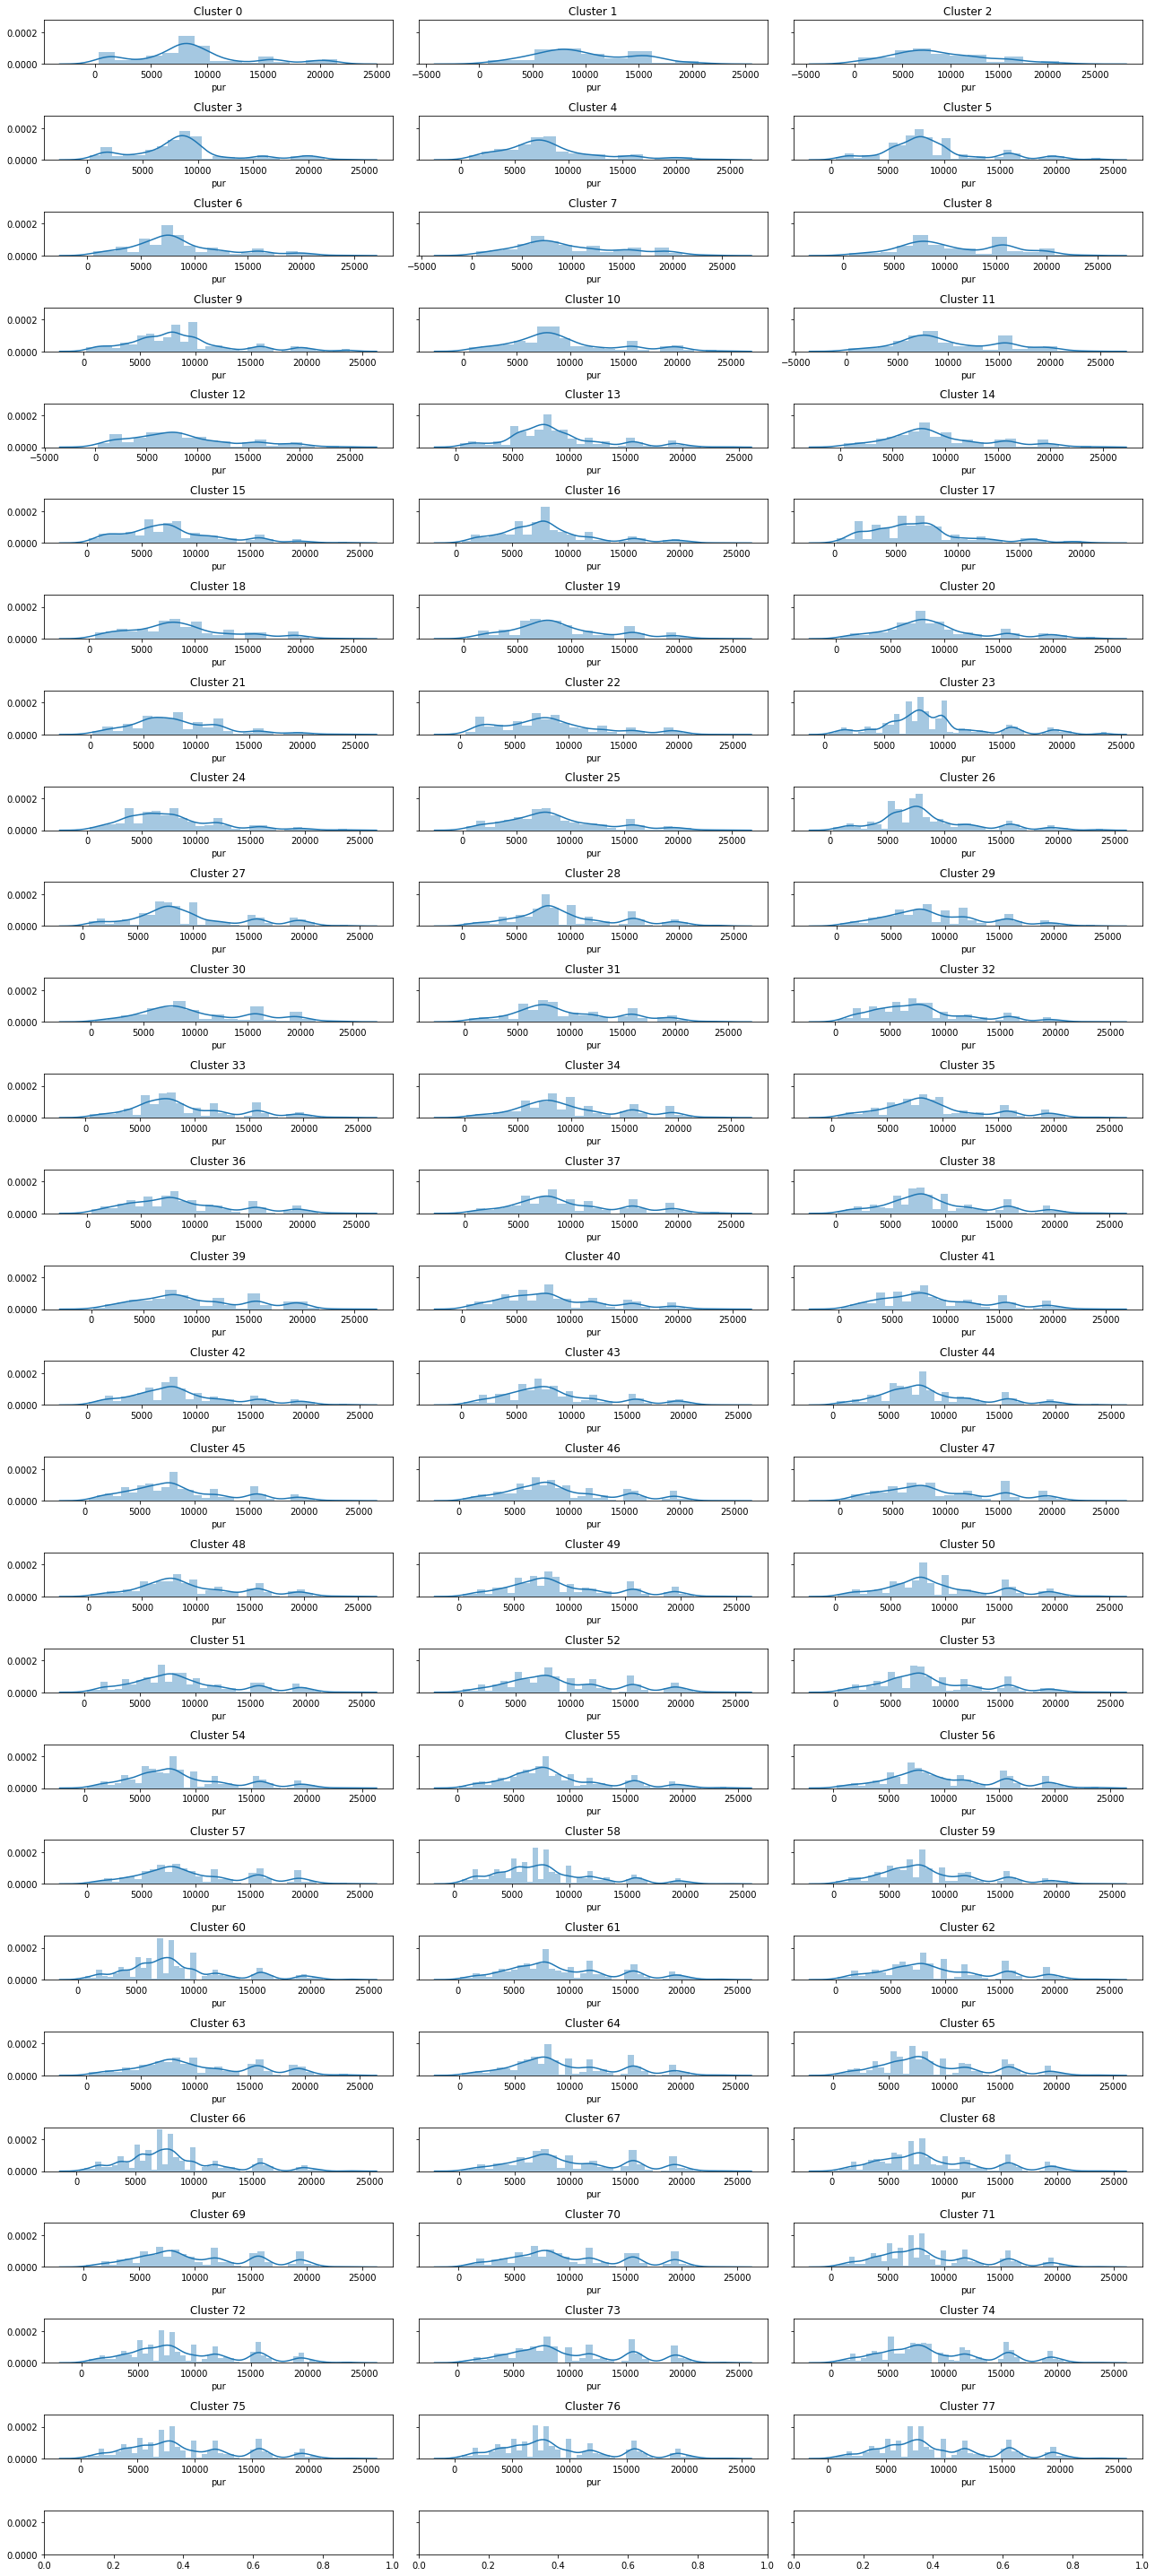

In [10]:
fig, axs = plt.subplots(len(custom_clusters)//3 + 1, 3, figsize = (18,40), sharey=True)
for i, cluster in enumerate(custom_clusters):
    axs[i//3, i%3].set_title("Cluster %d" % i)
    sns.distplot(cluster['pur'], ax = axs[i//3, i%3])
plt.tight_layout()

                                           Plots for gender                                           


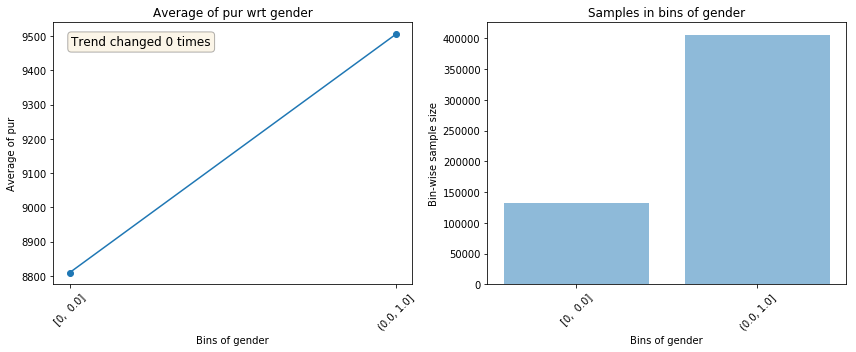

--------------------------------------------------------------------------------------------------------------


                                            Plots for age                                             


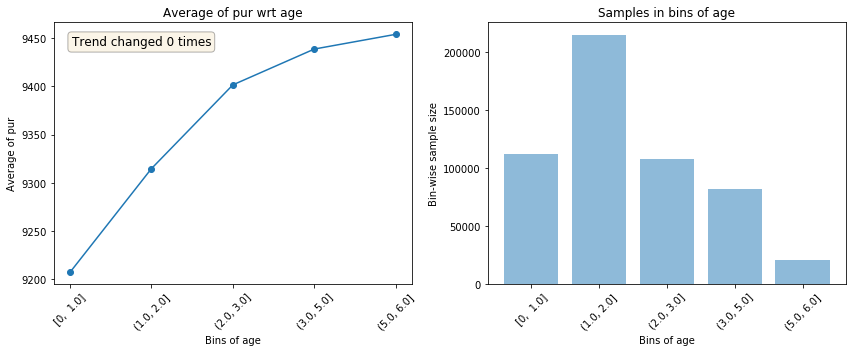

--------------------------------------------------------------------------------------------------------------


                                       Plots for years_in_city                                        


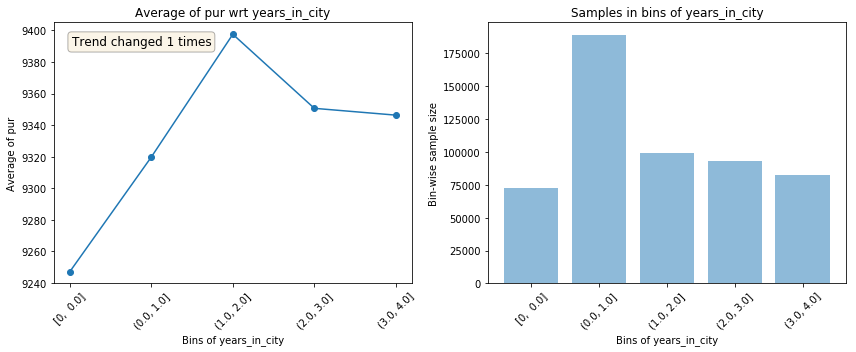

--------------------------------------------------------------------------------------------------------------


                                          Plots for married                                           


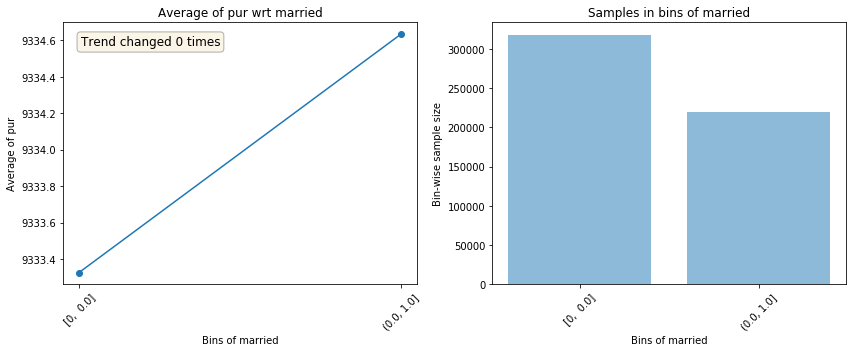

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_0                                            


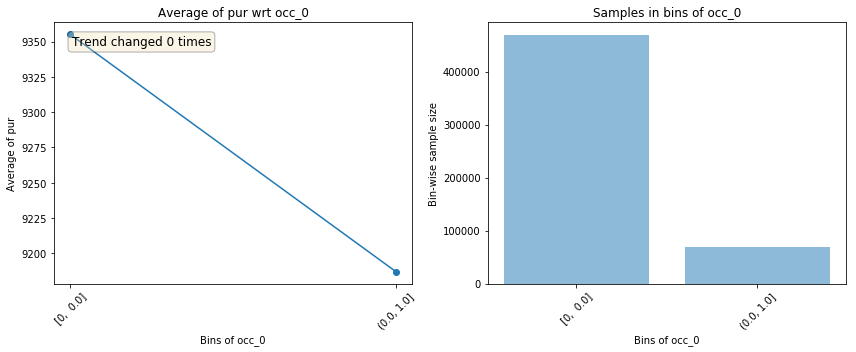

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_1                                            


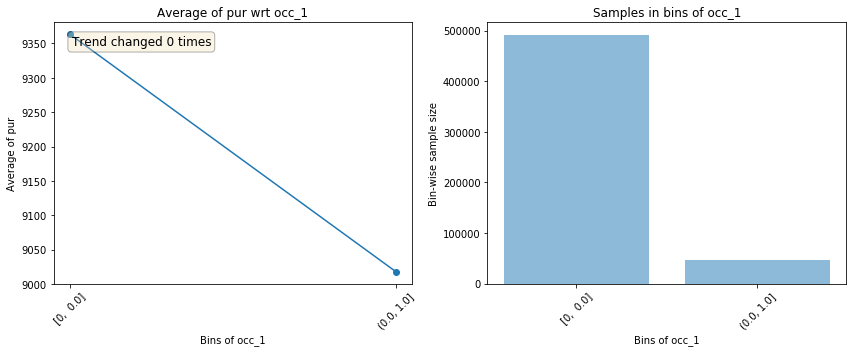

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_10                                           


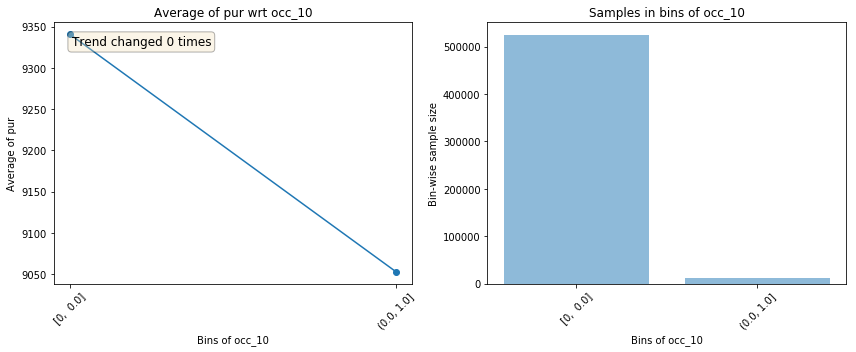

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_11                                           


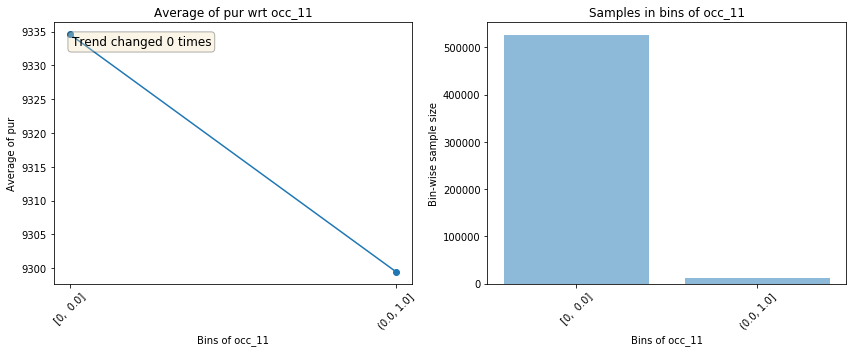

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_12                                           


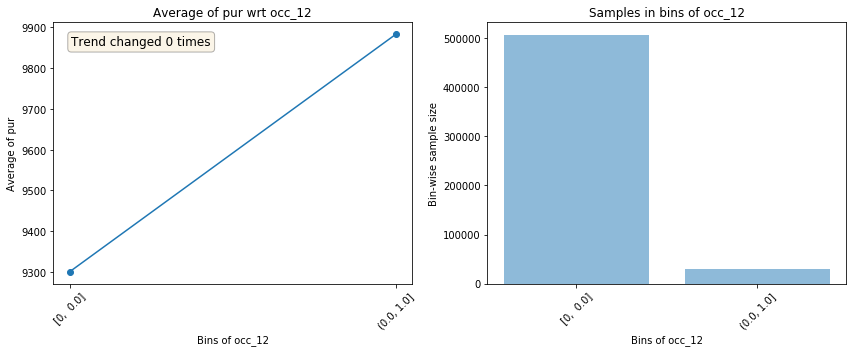

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_13                                           


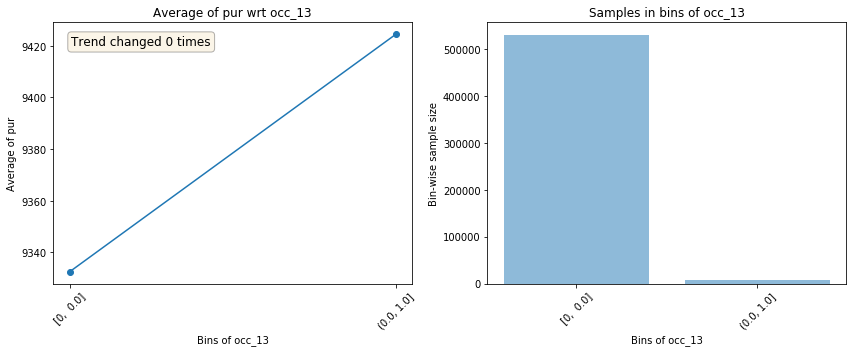

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_14                                           


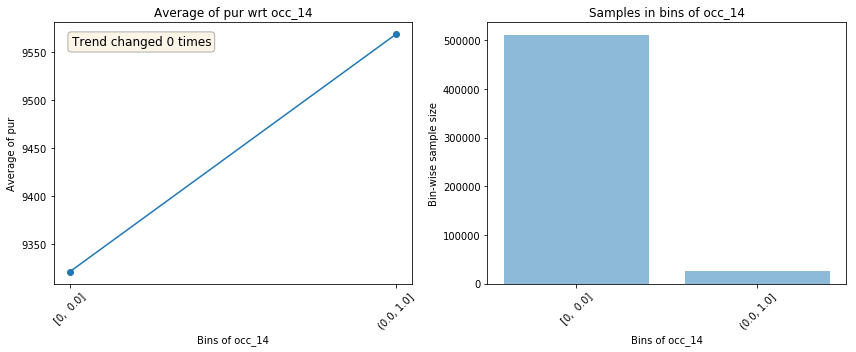

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_15                                           


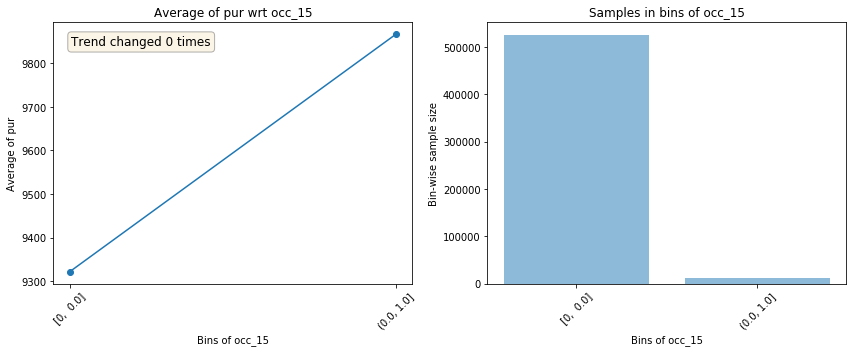

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_16                                           


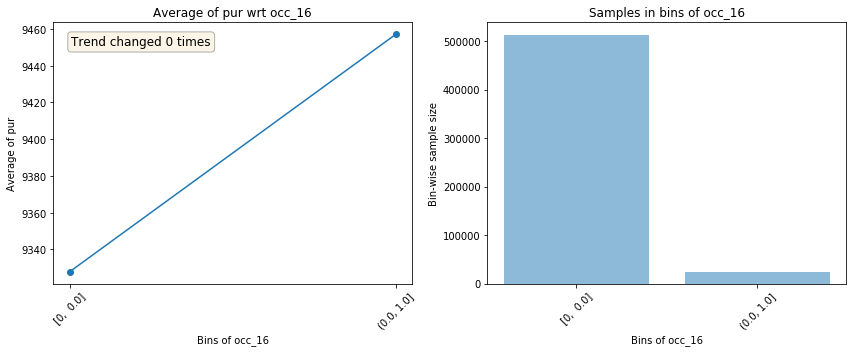

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_17                                           


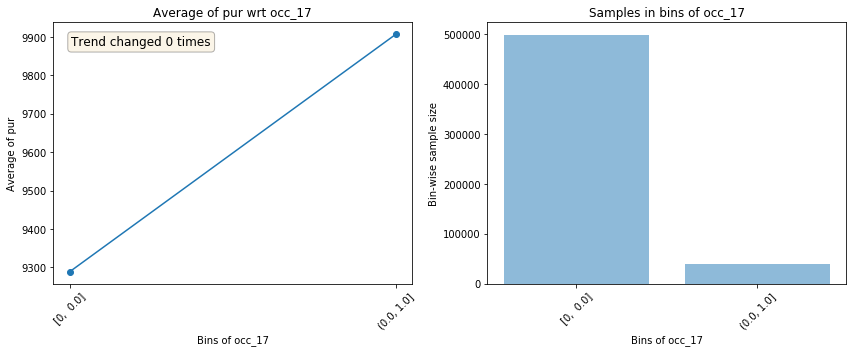

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_18                                           


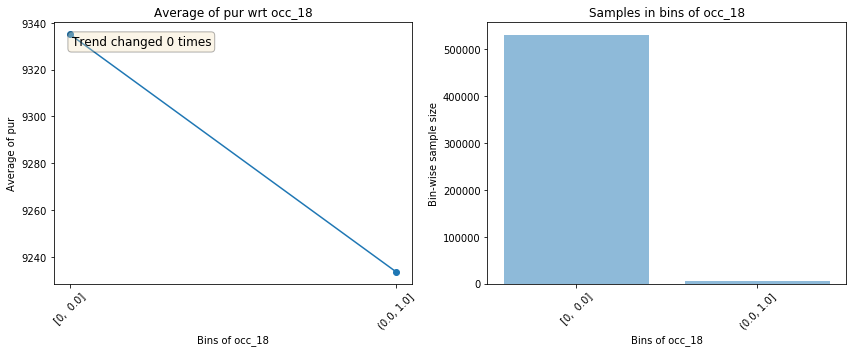

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_19                                           


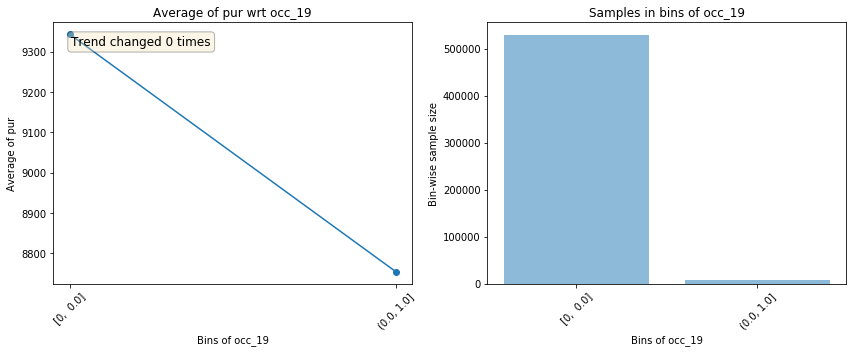

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_2                                            


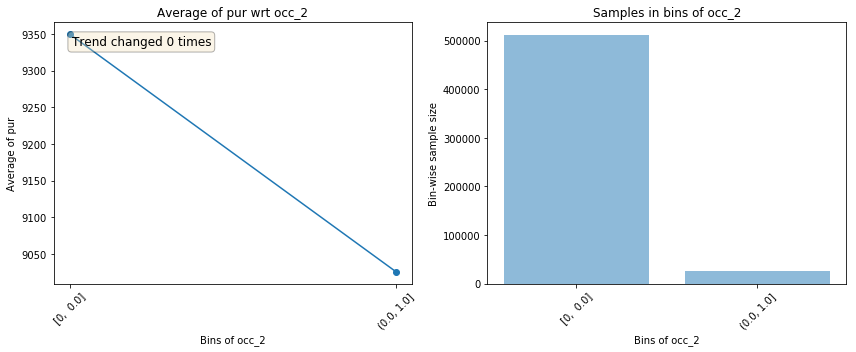

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_20                                           


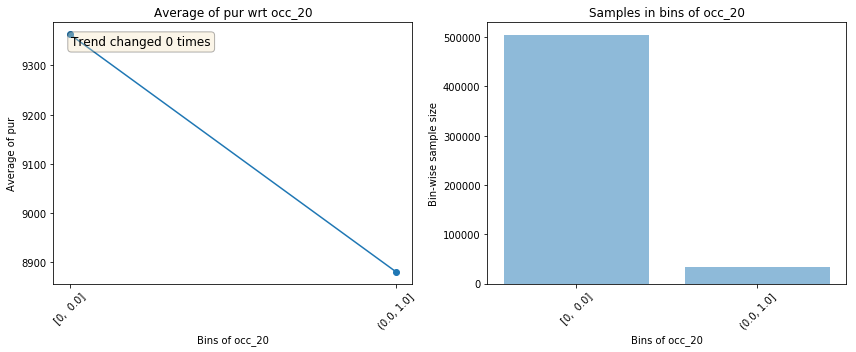

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_3                                            


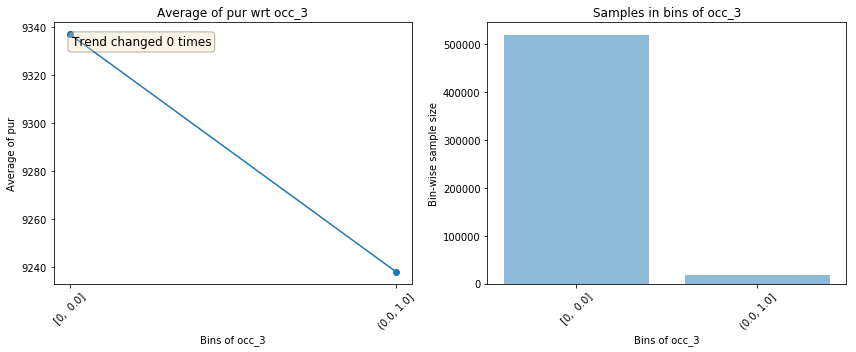

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_4                                            


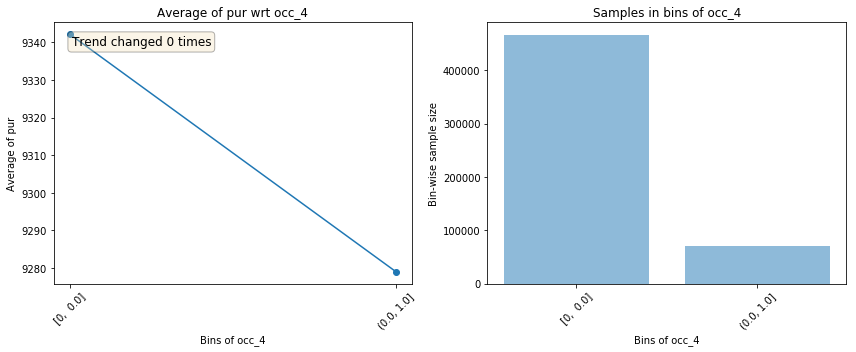

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_5                                            


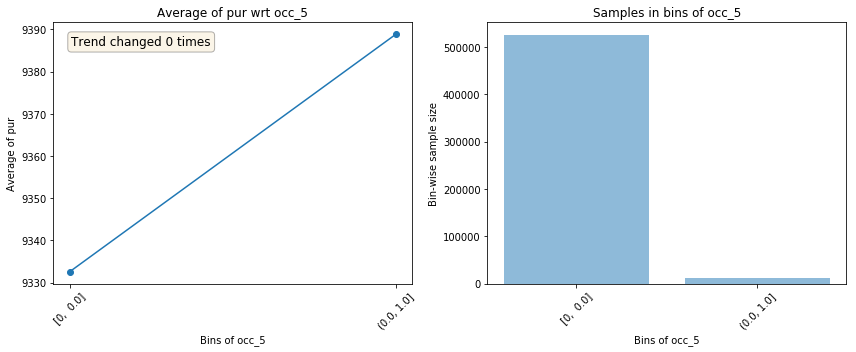

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_6                                            


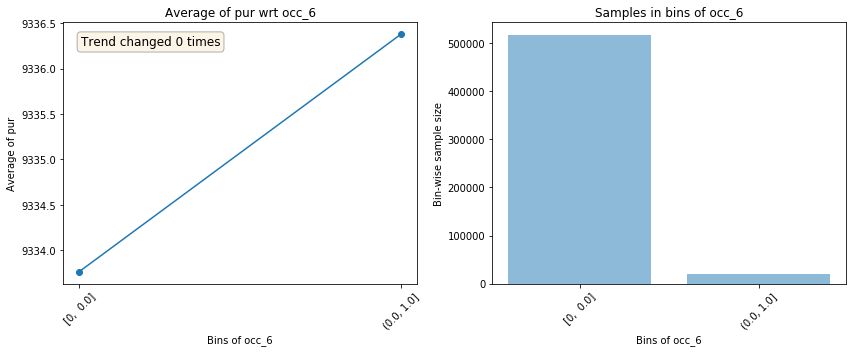

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_7                                            


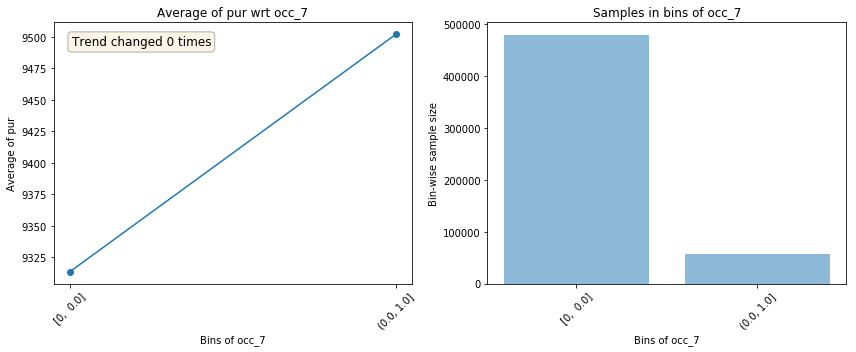

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_8                                            


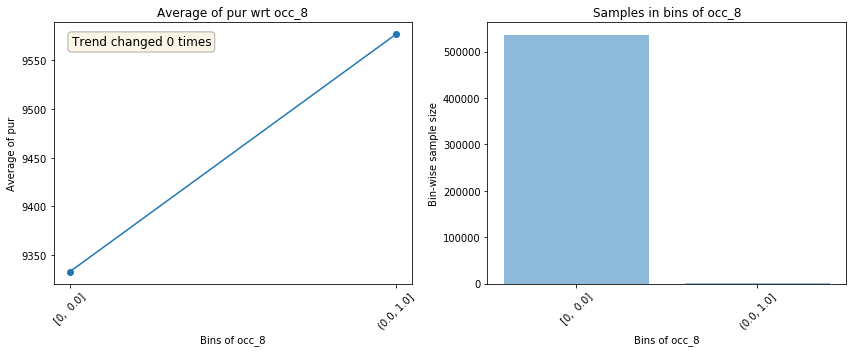

--------------------------------------------------------------------------------------------------------------


                                           Plots for occ_9                                            


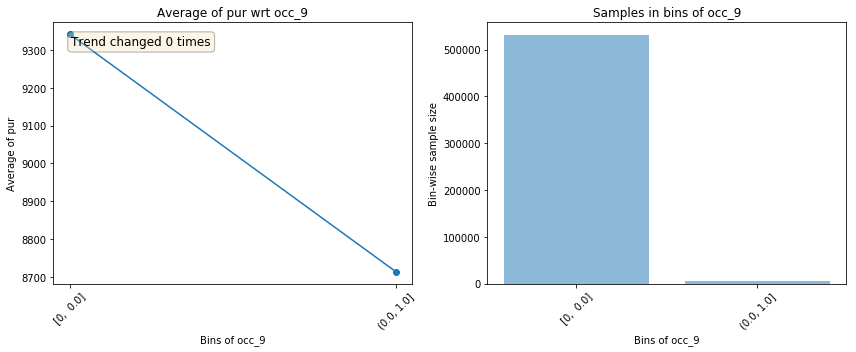

--------------------------------------------------------------------------------------------------------------


                                           Plots for city_A                                           


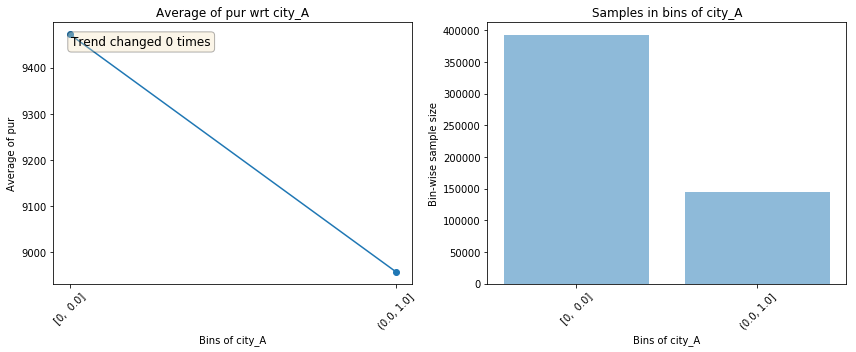

--------------------------------------------------------------------------------------------------------------


                                           Plots for city_B                                           


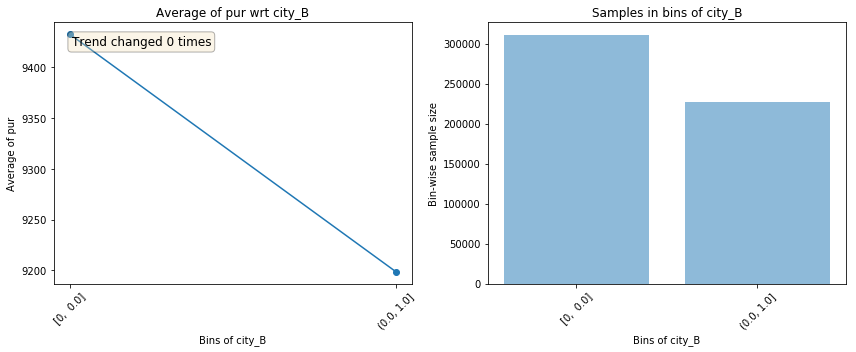

--------------------------------------------------------------------------------------------------------------


                                           Plots for city_C                                           


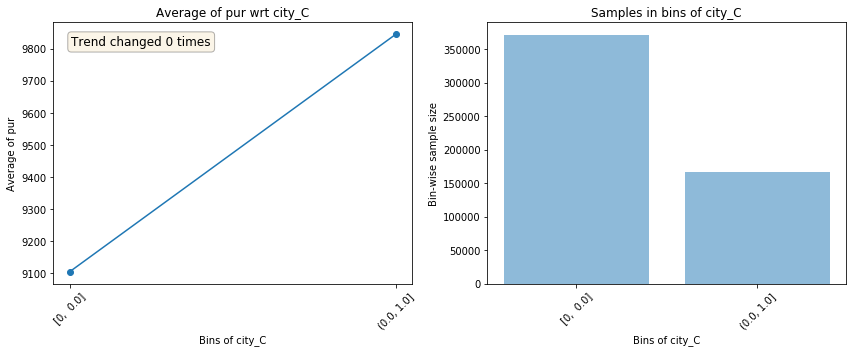

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_1                                          


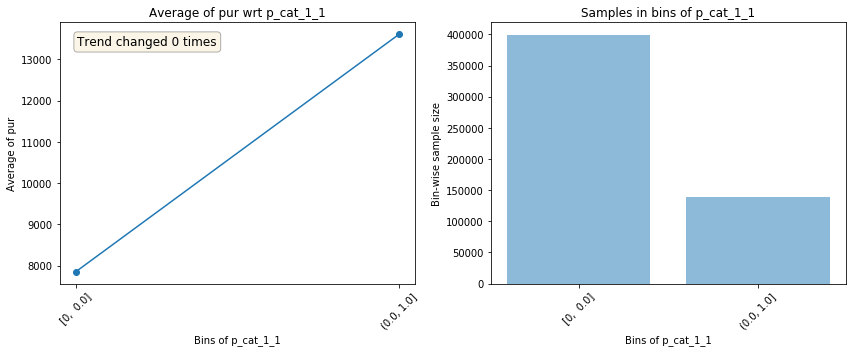

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_10                                         


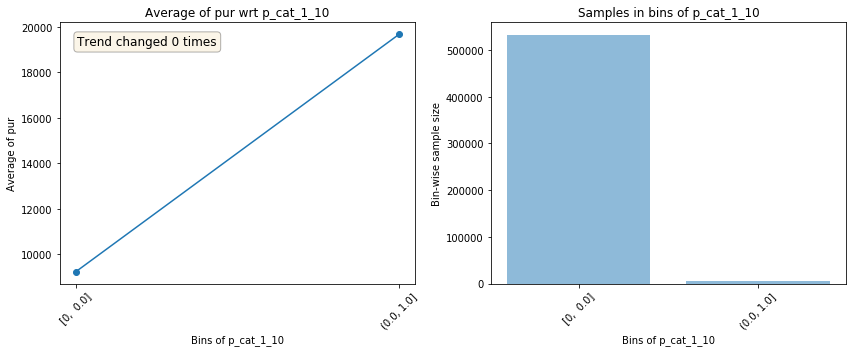

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_11                                         


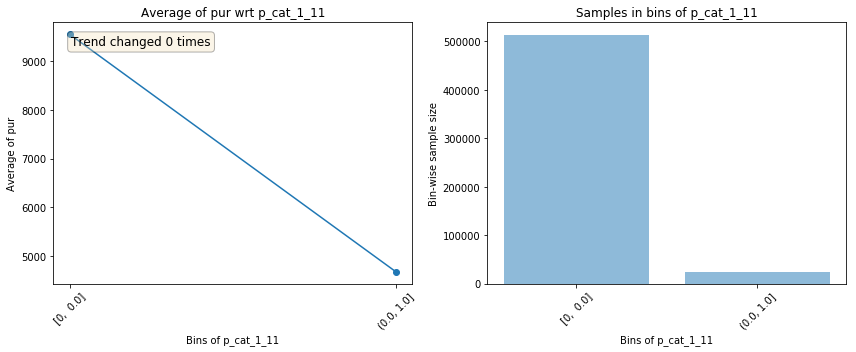

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_12                                         


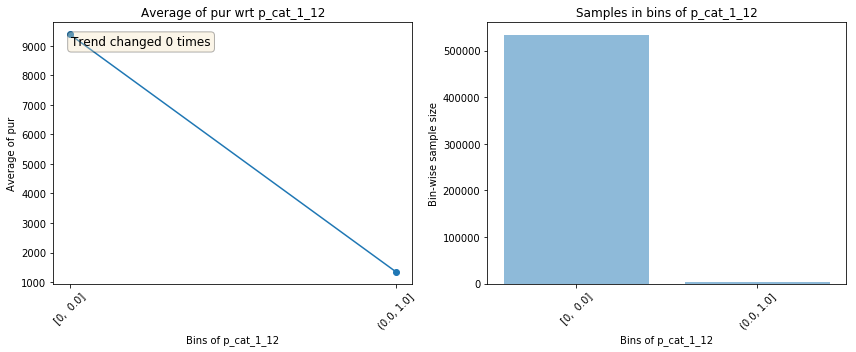

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_13                                         


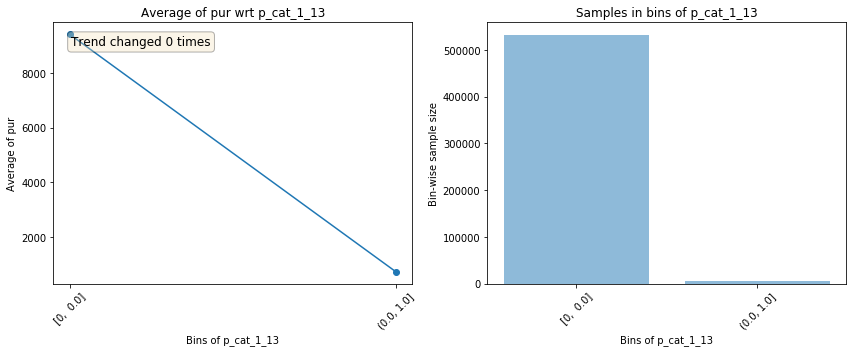

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_14                                         


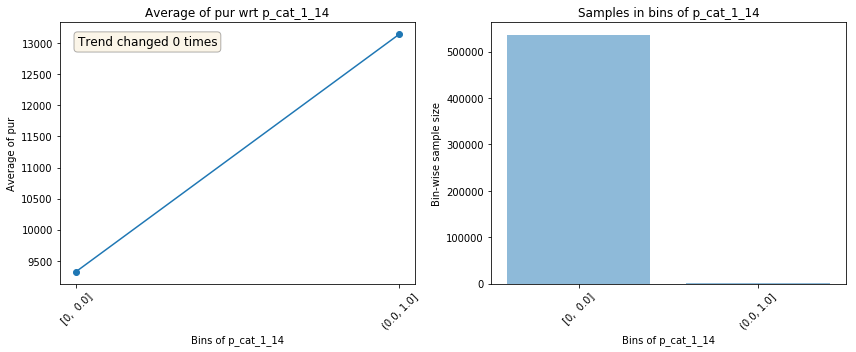

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_15                                         


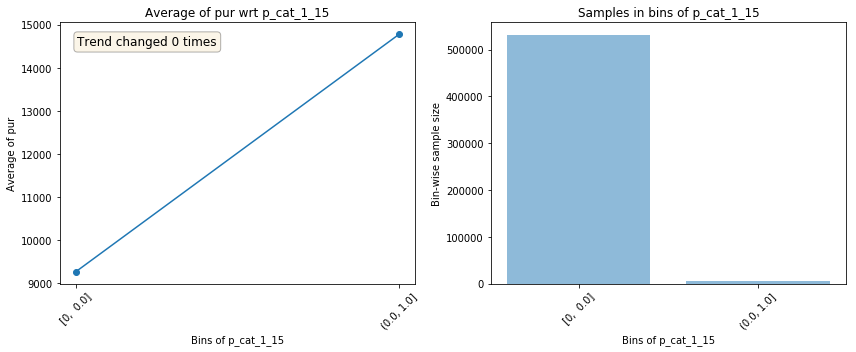

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_16                                         


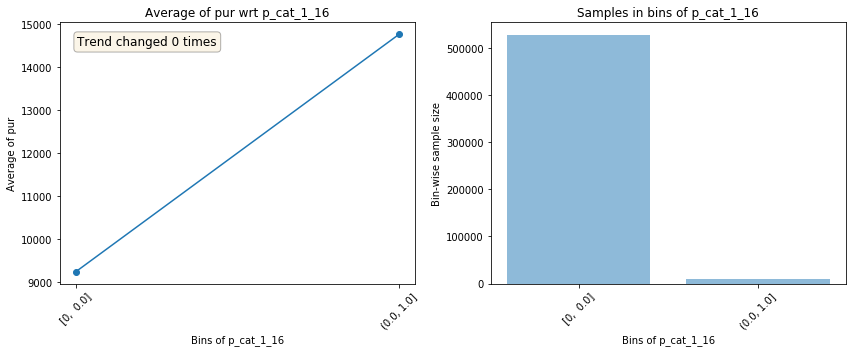

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_17                                         


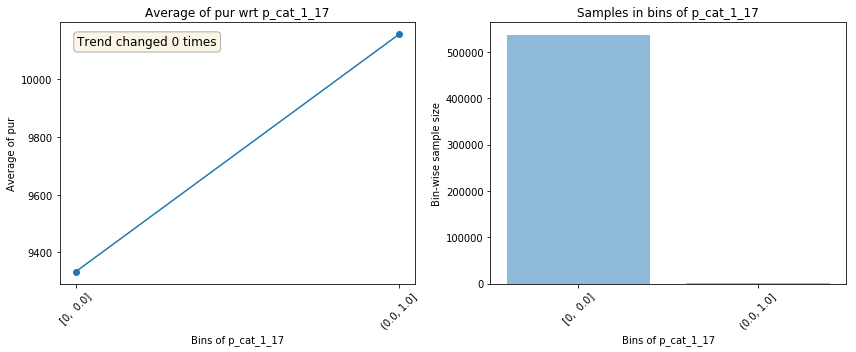

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_18                                         


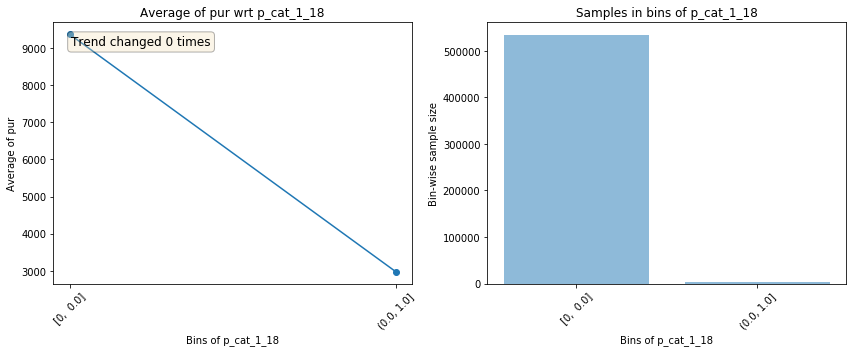

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_2                                          


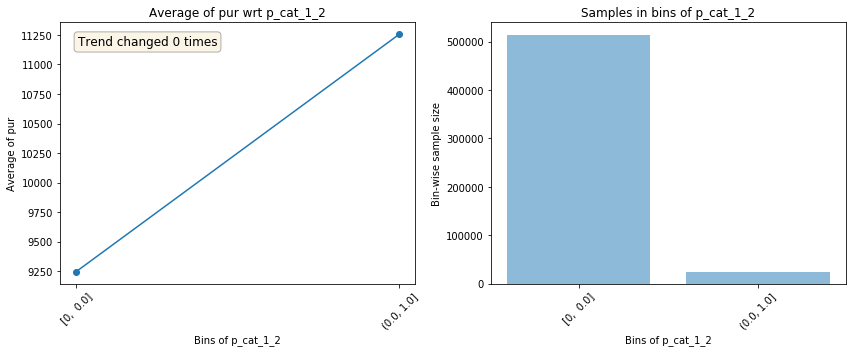

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_3                                          


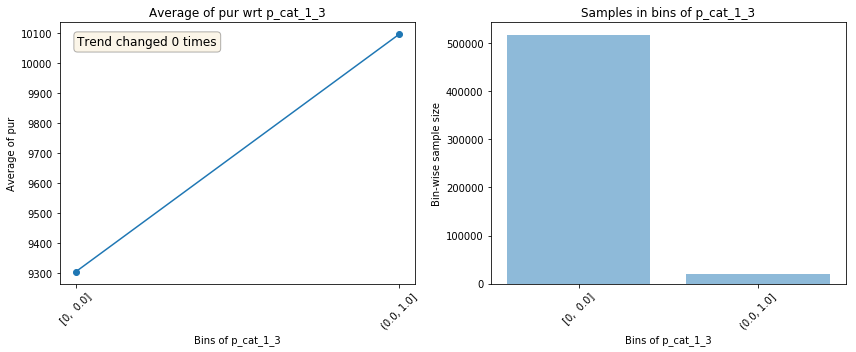

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_4                                          


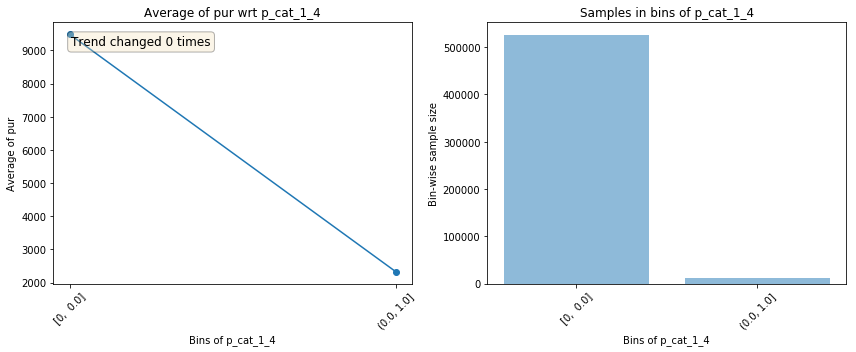

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_5                                          


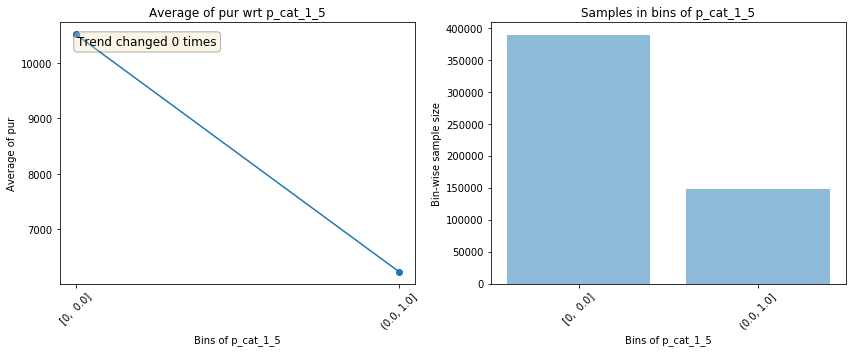

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_6                                          


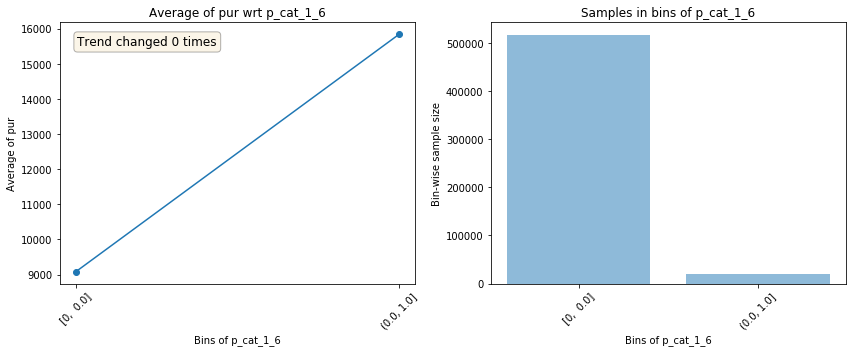

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_7                                          


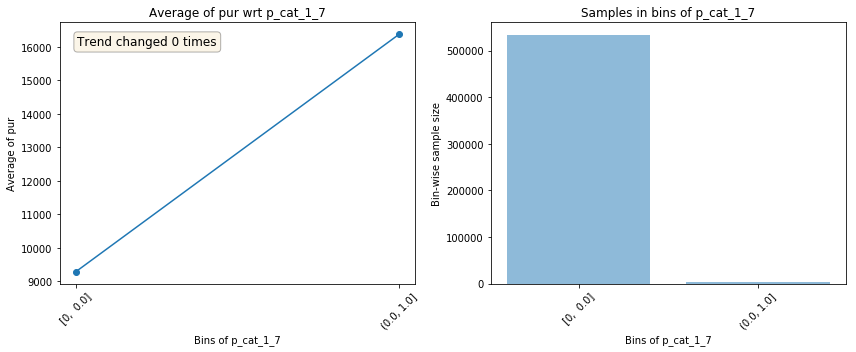

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_8                                          


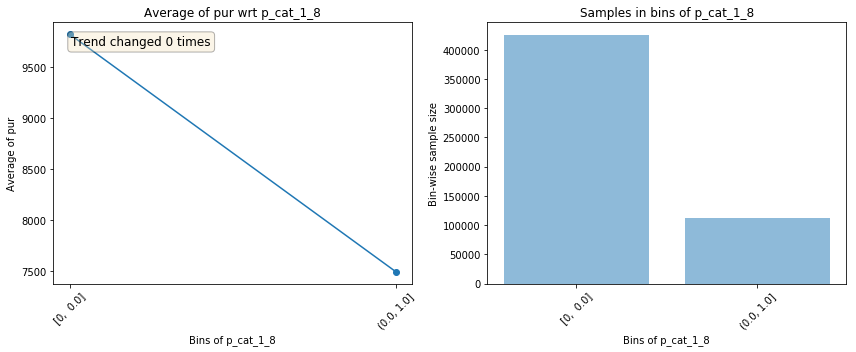

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_1_9                                          


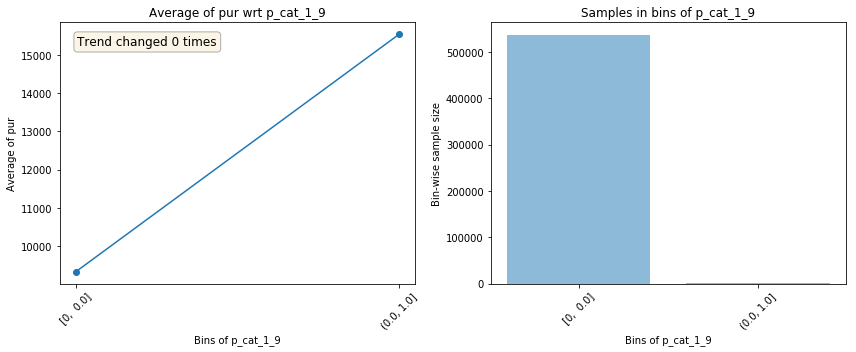

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_0                                          


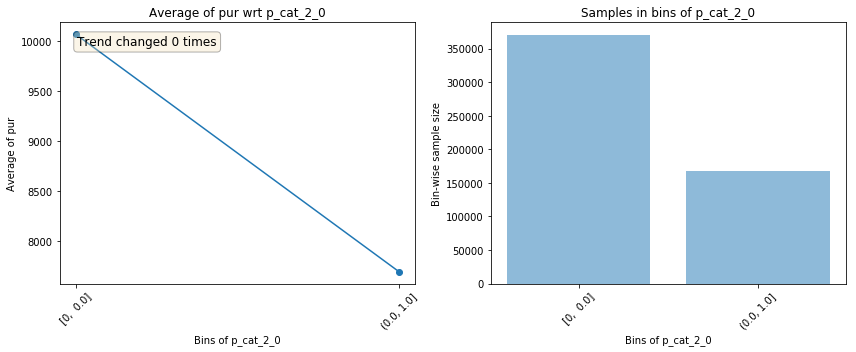

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_10                                         


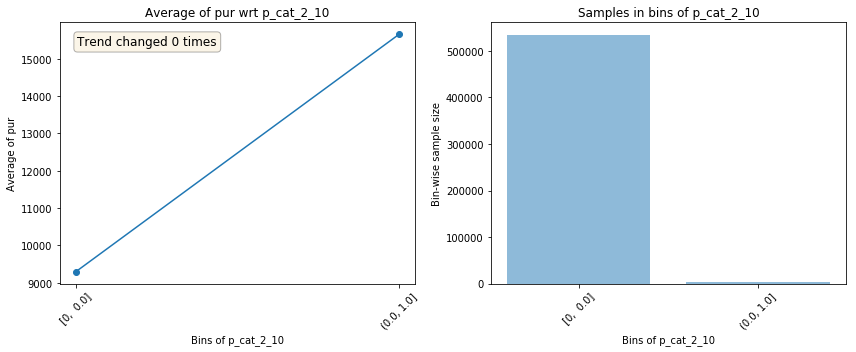

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_11                                         


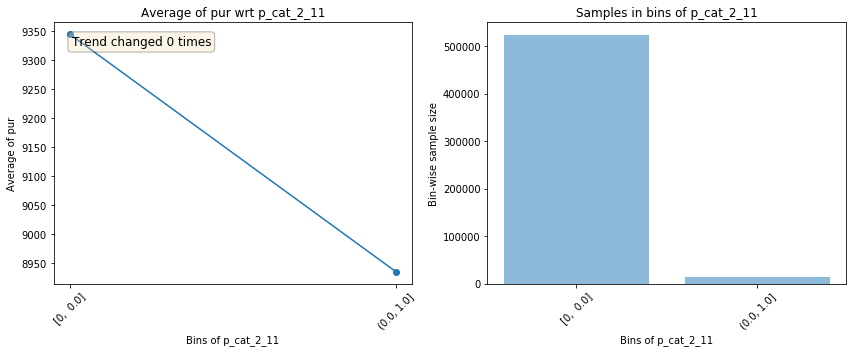

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_12                                         


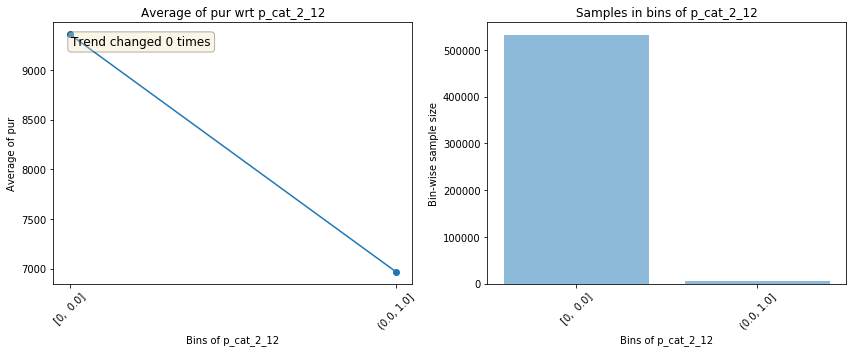

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_13                                         


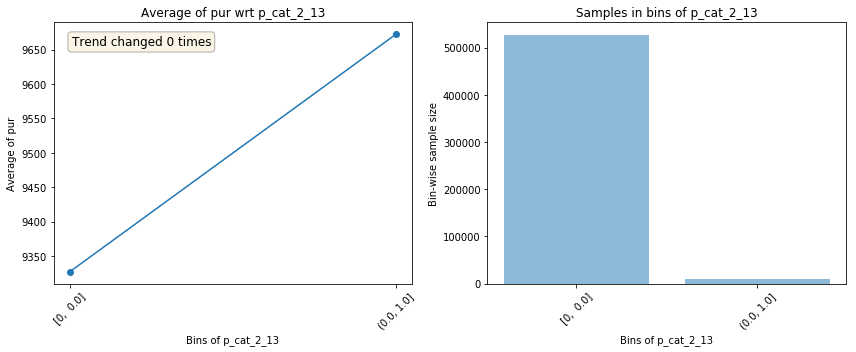

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_14                                         


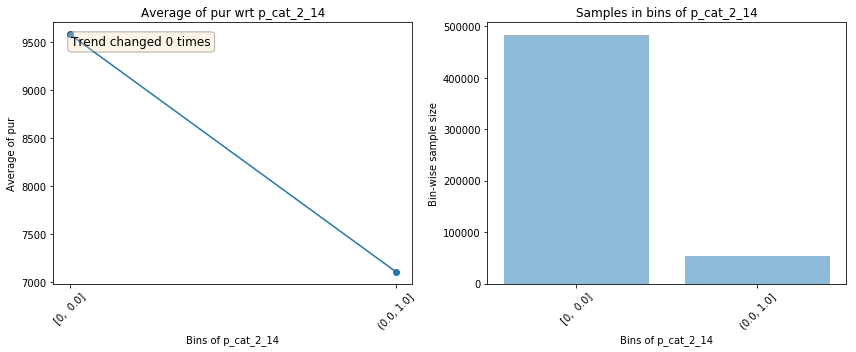

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_15                                         


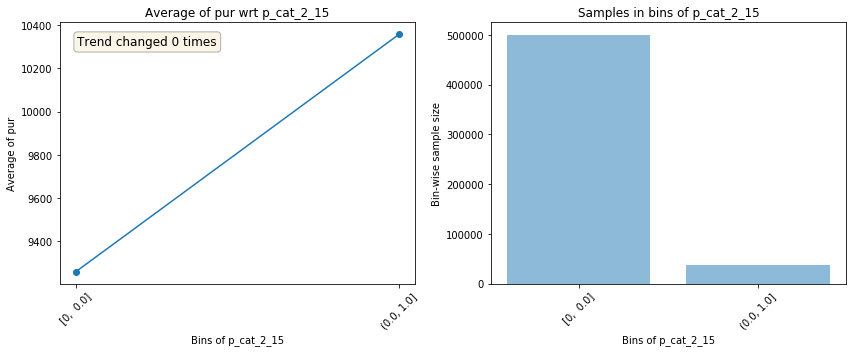

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_16                                         


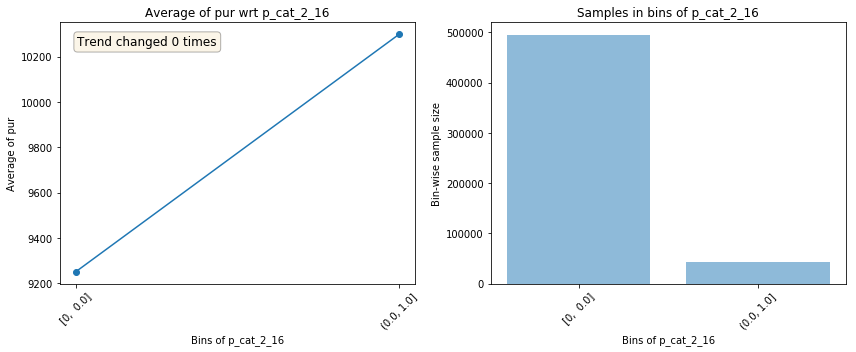

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_17                                         


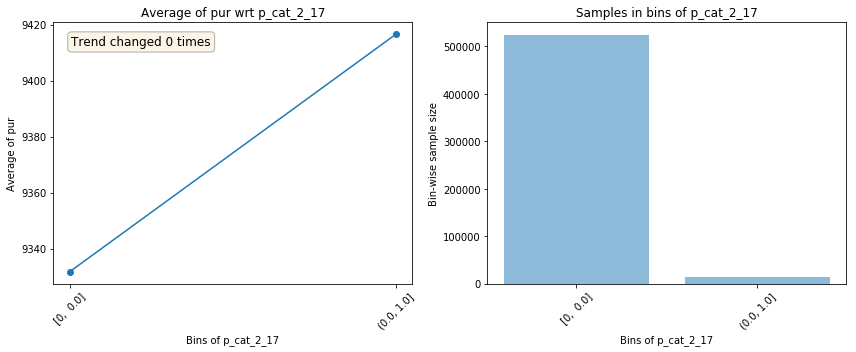

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_18                                         


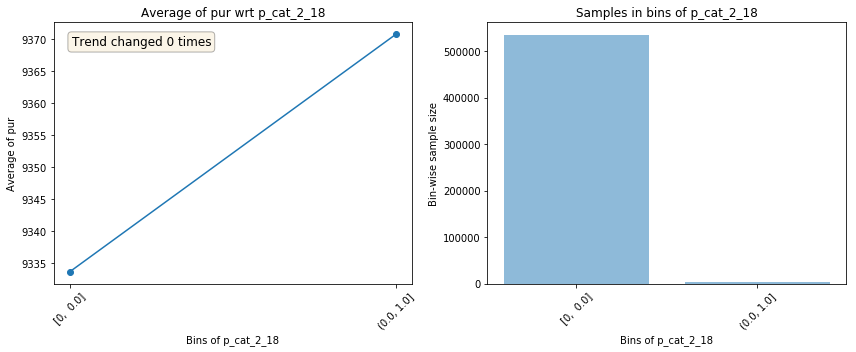

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_2                                          


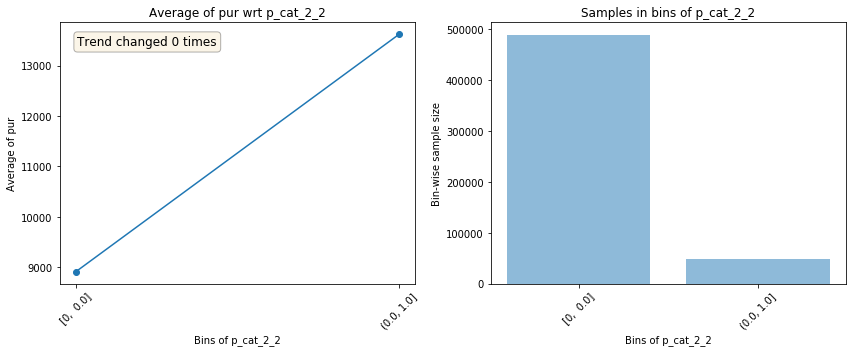

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_3                                          


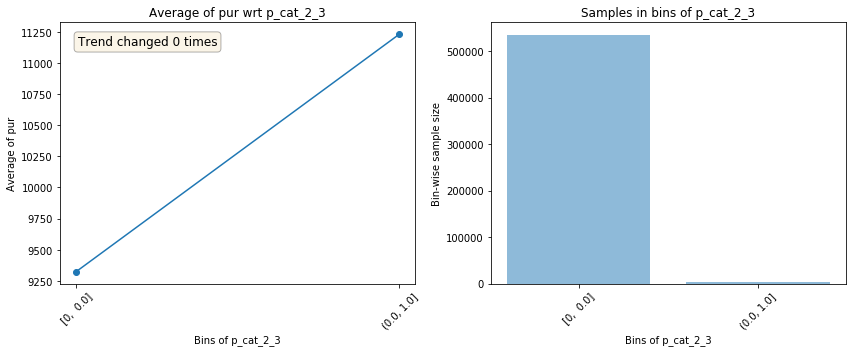

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_4                                          


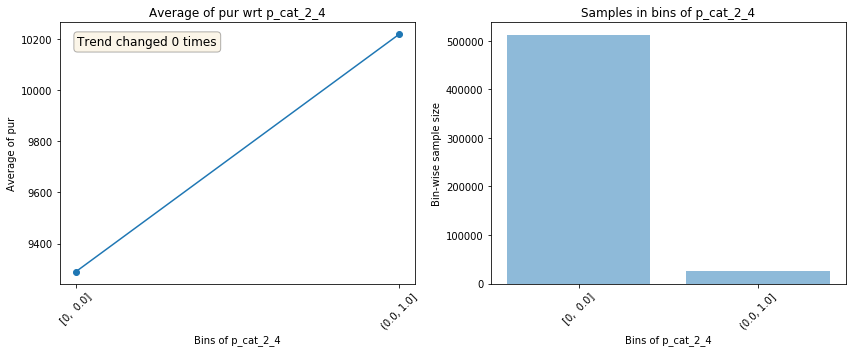

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_5                                          


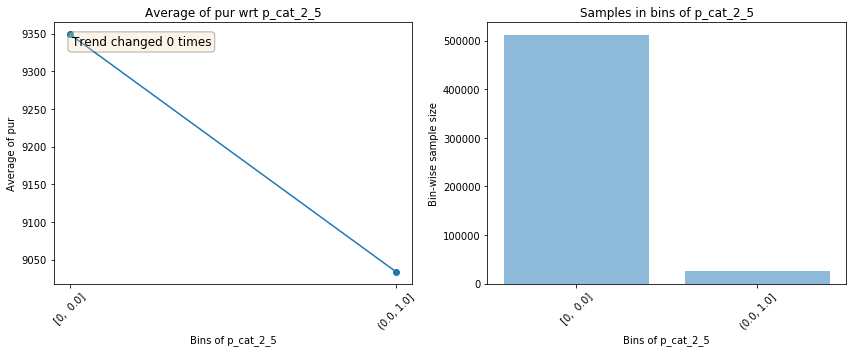

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_6                                          


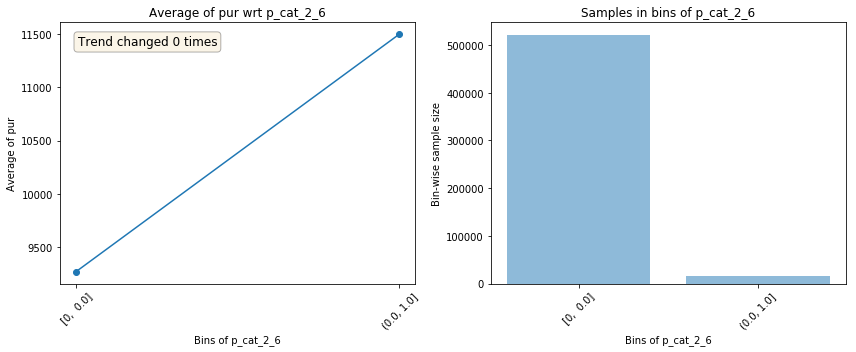

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_7                                          


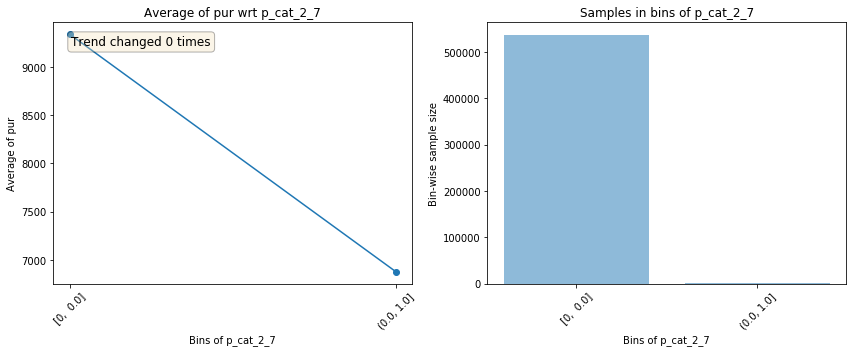

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_8                                          


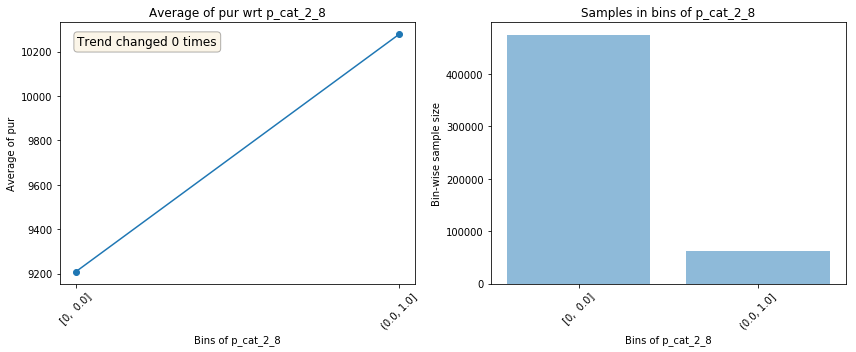

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_2_9                                          


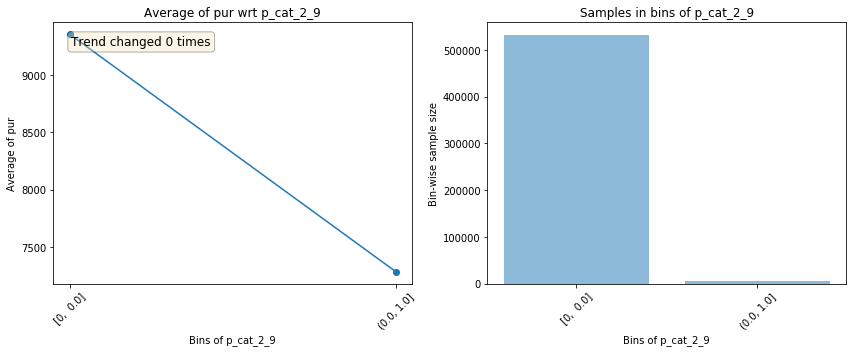

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_0                                          


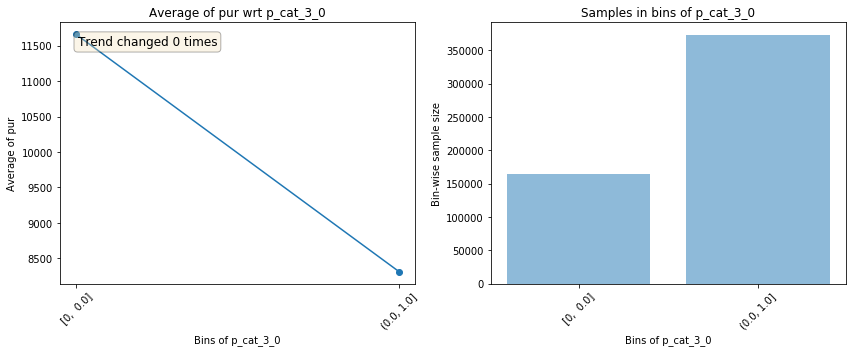

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_10                                         


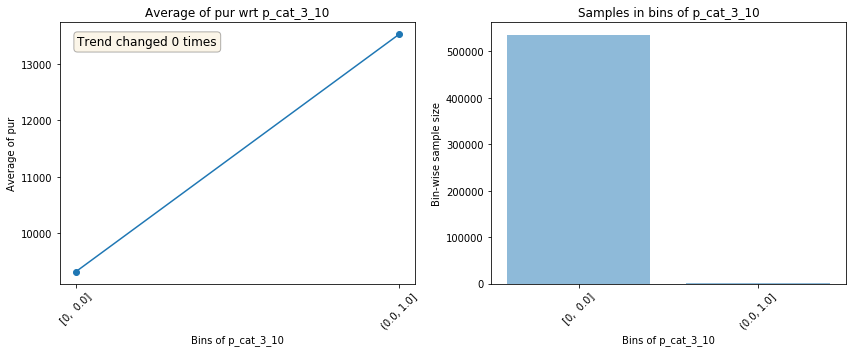

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_11                                         


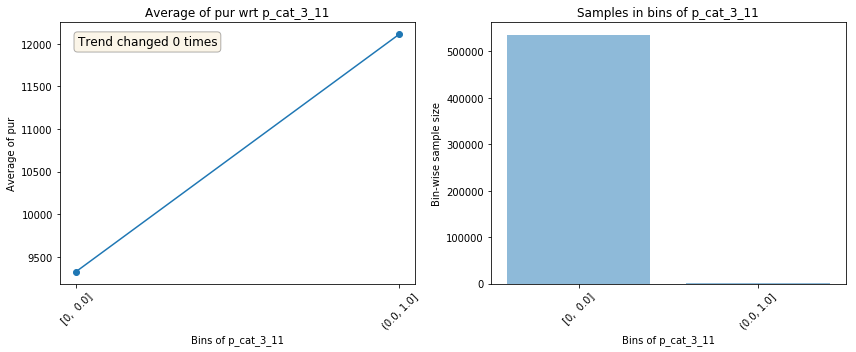

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_12                                         


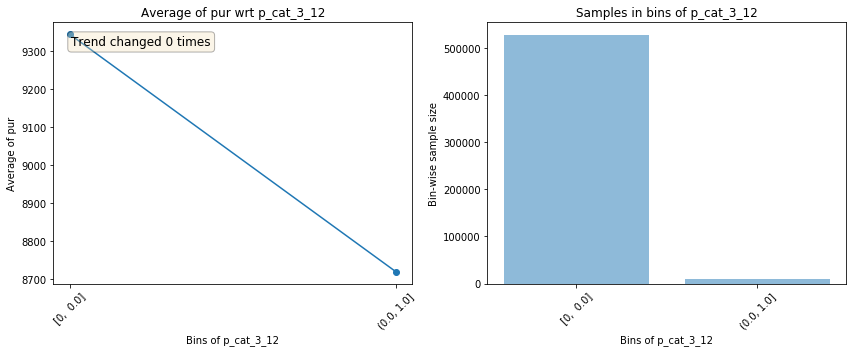

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_13                                         


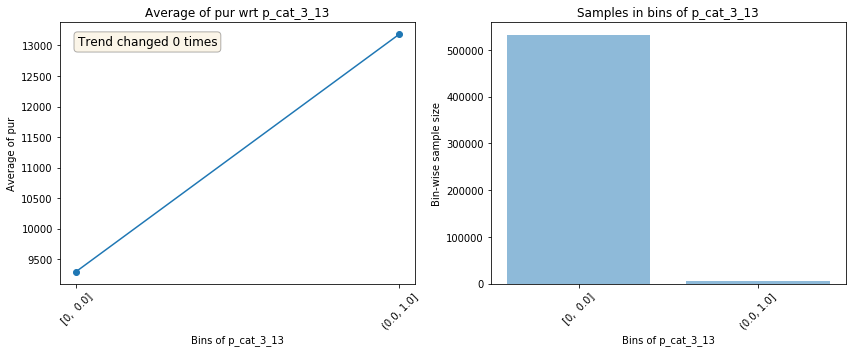

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_14                                         


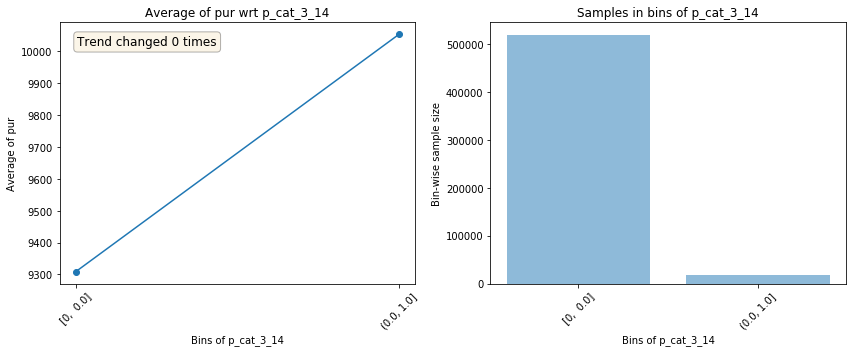

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_15                                         


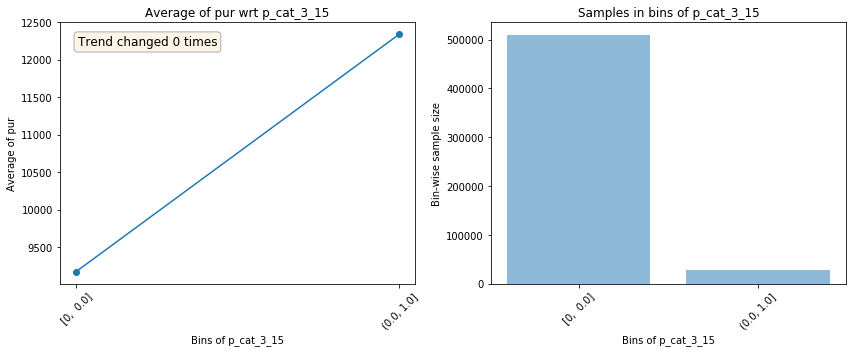

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_16                                         


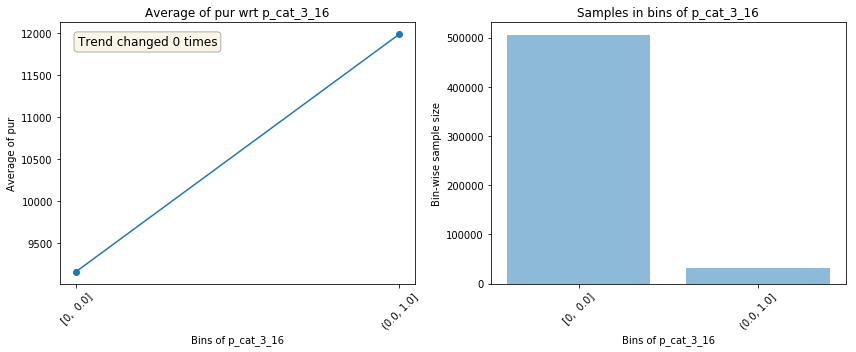

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_17                                         


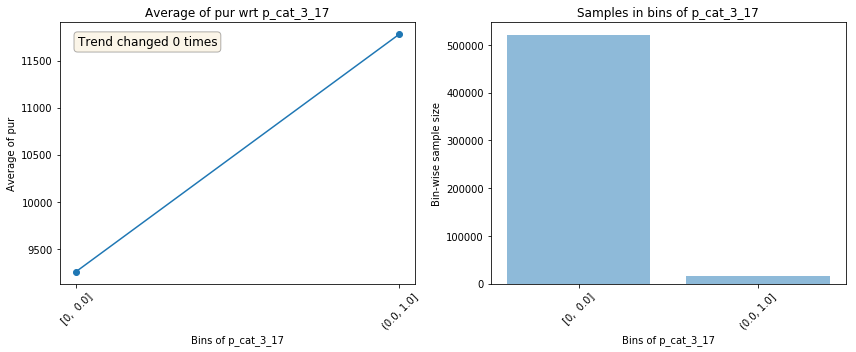

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_18                                         


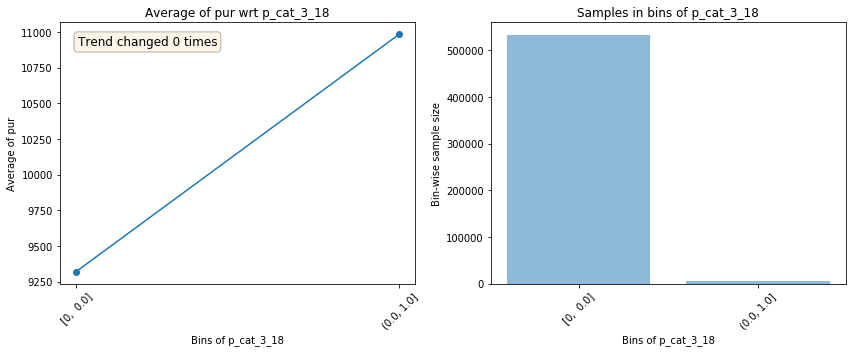

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_3                                          


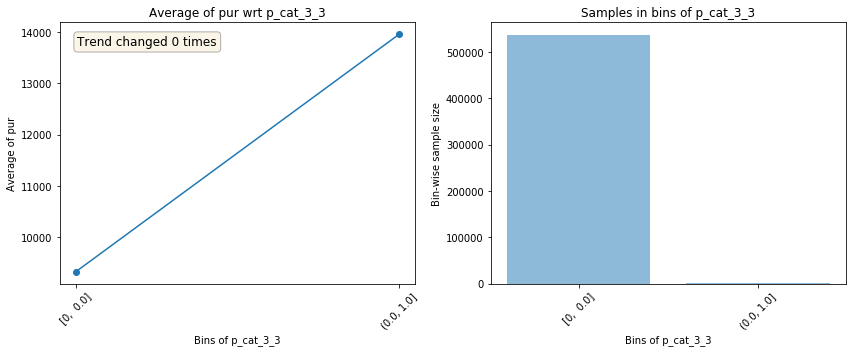

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_4                                          


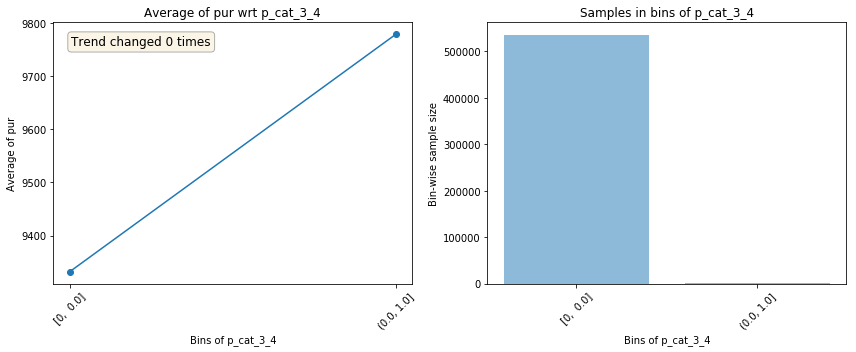

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_5                                          


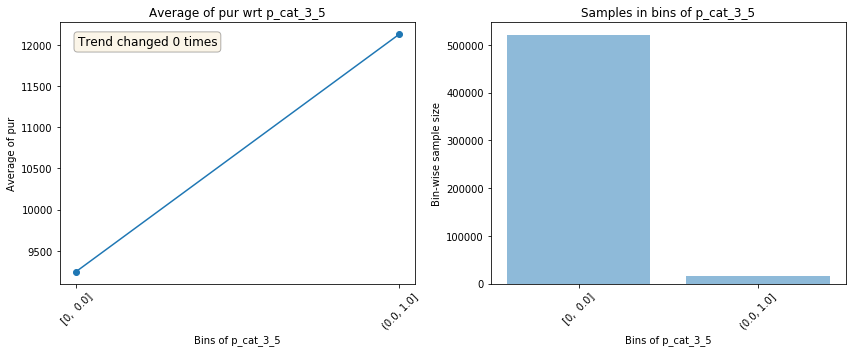

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_6                                          


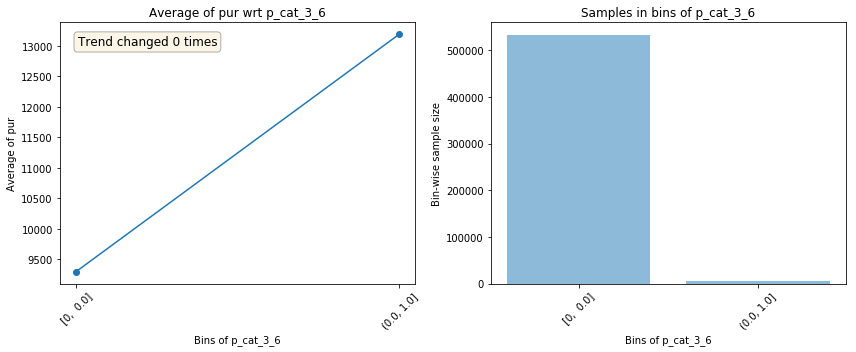

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_8                                          


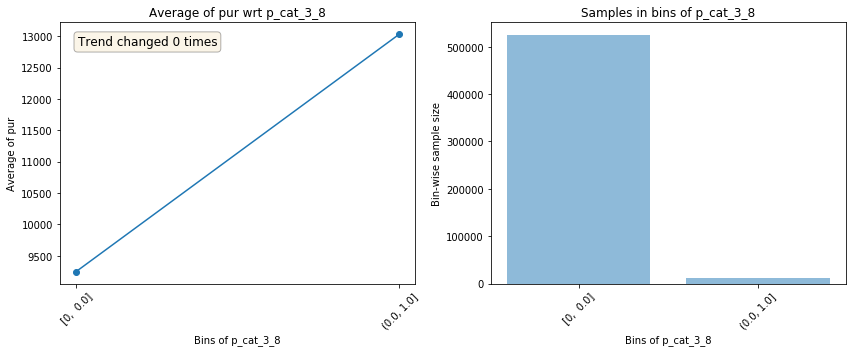

--------------------------------------------------------------------------------------------------------------


                                         Plots for p_cat_3_9                                          


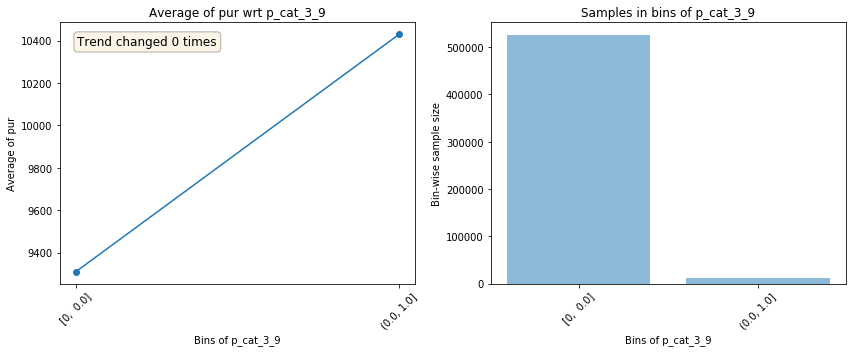

--------------------------------------------------------------------------------------------------------------




In [48]:
plot_types = ['gender', 'married', 'age', 'years_in_city', 'occ', 'p_cat_1', 'p_cat_2', 'p_cat_3']

get_univariate_plots(data=modeldf, target_col='pur', 
                     features_list= modeldf.drop('pur', axis = 1).columns, bins=10)

In [49]:
# Train and testing data for model dataset
X_train, X_test, y_train, y_test = train_test_split(modeldf,y,test_size = 0.25, random_state=30)

y_train = np.array(y_train).T.reshape(1, -1)[0]
y_test = np.array(y_test).T.reshape(1, -1)[0]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


stats = get_trend_stats(data=X_train, target_col='pur', data_test=X_test)
stats

(403182, 81) (134395, 81) (403182,) (134395,)
Returning stats for all numeric features


Feature  Trend_changes  Trend_changes_test  Trend_correlation
0          gender              0                   0           1.000000
1             age              0                   0           0.957181
2   years_in_city              1                   1           0.789143
3         married              0                   0           1.000000
4           occ_0              0                   0           1.000000
5           occ_1              0                   0           1.000000
6          occ_10              0                   0           1.000000
7          occ_11              0                   0           1.000000
8          occ_12              0                   0           1.000000
9          occ_13              0                   0           1.000000
10         occ_14              0                   0           1.000000
11         occ_15              0                   0           1.000000
12         occ_16              0                   0           1.000000
13         occ_17              0                   0           1.000000
14         occ_18              0                   0           1.000000
15         occ_19              0                   0           1.000000
16          occ_2              0                   0           1.000000
17         occ_20              0                   0           1.000000
18          occ_3              0                   0           1.000000
19          occ_4              0                   0           1.000000
20          occ_5              0                   0           1.000000
21          occ_6              0                   0          -1.000000
22          occ_7              0                   0           1.000000
23          occ_8              0                   0           1.000000
24          occ_9              0                   0           1.000000
25         city_A              0                   0           1.000000
26         city_B              0                   0           1.000000
27         city_C              0                   0           1.000000
28      p_cat_1_1              0                   0           1.000000
29     p_cat_1_10              0                   0           1.000000
..            ...            ...                 ...                ...
50     p_cat_2_13              0                   0           1.000000
51     p_cat_2_14              0                   0           1.000000
52     p_cat_2_15              0                   0           1.000000
53     p_cat_2_16              0                   0           1.000000
54     p_cat_2_17              0                   0           1.000000
55     p_cat_2_18              0                   0          -1.000000
56      p_cat_2_2              0                   0           1.000000
57      p_cat_2_3              0                   0           1.000000
58      p_cat_2_4              0                   0           1.000000
59      p_cat_2_5              0                   0           1.000000
60      p_cat_2_6              0                   0           1.000000
61      p_cat_2_7              0                   0           1.000000
62      p_cat_2_8              0                   0           1.000000
63      p_cat_2_9              0                   0           1.000000
64      p_cat_3_0              0                   0           1.000000
65     p_cat_3_10              0                   0           1.000000
66     p_cat_3_11              0                   0           1.000000
67     p_cat_3_12              0                   0           1.000000
68     p_cat_3_13              0                   0           1.000000
69     p_cat_3_14              0                   0           1.000000
70     p_cat_3_15              0                   0           1.000000
71     p_cat_3_16              0                   0           1.000000
72     p_cat_3_17              0                   0           1.000000
73     p_cat_3_18              0                  

In [75]:
smaller_stats = stats[stats.Trend_correlation >= 0.9]
X_small = modeldf[smaller_stats.Feature]
X_small

gender  age  years_in_city  married  occ_0  occ_1  occ_10  occ_11  \
0            0    0              2        0      0      0       1       0   
1            0    0              2        0      0      0       1       0   
2            0    0              2        0      0      0       1       0   
3            0    0              2        0      0      0       1       0   
4            1    6              4        0      0      0       0       0   
5            1    2              3        0      0      0       0       0   
6            1    4              2        1      0      0       0       0   
7            1    4              2        1      0      0       0       0   
8            1    4              2        1      0      0       0       0   
9            1    2              1        1      0      0       0       0   
10           1    2              1        1      0      0       0       0   
11           1    2              1        1      0      0       0       0   
12           1    2              1        1      0      0       0       0   
13           1    2              1        1      0      0       0       0   
14           0    5              1        0      0      0       0       0   
15           0    5              1        0      0      0       0       0   
16           0    5              1        0      0      0       0       0   
17           0    5              1        0      0      0       0       0   
18           1    3              1        1      0      1       0       0   
19           1    2              4        1      0      0       0       0   
20           1    2              4        1      0      0       0       0   
21           1    2              4        1      0      0       0       0   
22           1    2              4        1      0      0       0       0   
23           1    2              4        1      0      0       0       0   
24           1    2              4        1      0      0       0       0   
25           1    2              0        0      0      0       0       0   
26           1    2              0        0      0      0       0       0   
27           1    2              0        0      0      0       0       0   
28           1    2              0        0      0      0       0       0   
29           0    3              4        1      0      1       0       0   
...        ...  ...            ...      ...    ...    ...     ...     ...   
537546       1    1              1        0      0      0       0       0   
537547       1    1              1        0      0      0       0       0   
537549       1    5              1        1      0      1       0       0   
537550       1    4              3        0      0      0       0       0   
537551       1    4              3        0      0      0       0       0   
537552       1    4              3        0      0      0       0       0   
537553       1    4              3        0      0      0       0       0   
537554       1    4              3        0      0      0       0       0   
537555       1    4              3        0      0      0       0       0   
537556       1    1              1        1      0      0       0       0   
537557       1    1              1        1      0      0       0       0   
537558       1    1              1        1      0      0       0       0   
537559       1    1              1        1      0      0       0       0   
537560       1    1              1        1      0      0       0       0   
537561       1    1              1        1      0      0       0       0   
537562       1    1              1        1      0      0       0       0   
537563       1    1              1        1      0      0       0       0   
537564       1    1              1        1      0      0       0       0   
537565       1    1              1        1      0      0       0       0   
537566       1    1              1        1      0      0       0       0   
5375

# Preprocessing Modeling

### Principle Componenet Analysis

In [9]:
# Generates principal component dataset

def create_pca_modeldf(X, demo_cols, per_variance_captured = .95):
    
    all_X = X
    X = X[demo_cols]
    pca = PCA()
    if 'p_id' in X.columns:
        pca.fit(X.drop('p_id', axis = 1))
    else:
        pca.fit(X)
    plt.subplots(2,1, figsize=(15,5))
    ax1 = plt.subplot(1,2,1)
    plt.plot(pca.explained_variance_ratio_, '-o')
    plt.xlabel("Principal Component")
    plt.ylabel("Pro. Variance Explained")
    ax1 = plt.subplot(1,2,2)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Pro. Variance Explained")
    plt.show()
    
    N3 = np.where(np.cumsum(pca.explained_variance_ratio_)>=per_variance_captured)[0][0] + 1
    print('90% of variance explained by {} principal components' .format(N3))

    n_components = N3
    pca = PCA(n_components = n_components)
    if 'p_id' in X.columns:
        principalComponents = pca.fit_transform(X.drop('p_id', axis = 1))
    else:
        principalComponents = pca.fit_transform(X)
    X_pca = pd.DataFrame(data = principalComponents, 
                               columns = ['pc_' + str(x) for x in range(pca.n_components_)])
    if 'p_id' in X.columns:
        X_pca = X_pca.join(X['p_id'])
    
    pca_cols = X_pca.columns
    X_pca = X_pca.join(all_X.drop(demo_cols, axis = 1))
    
    return X_pca, pca_cols

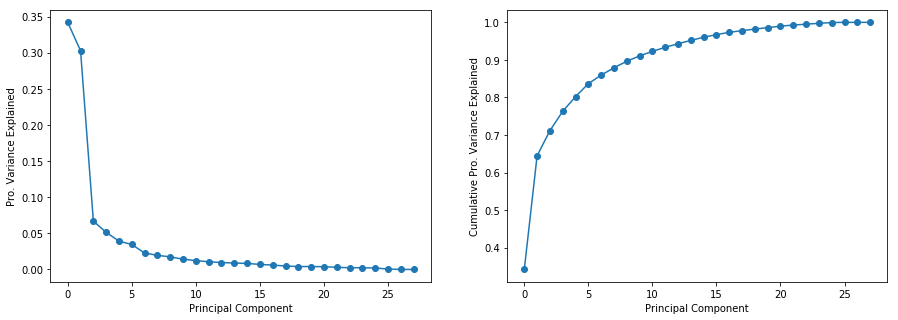

90% of variance explained by 14 principal components


pc_0      pc_1      pc_2      pc_3      pc_4      pc_5      pc_6  \
0 -2.570736  0.029066 -0.437812  0.632249  0.043709  0.765867  0.079981   
1 -2.570736  0.029066 -0.437812  0.632249  0.043709  0.765867  0.079981   
2 -2.570736  0.029066 -0.437812  0.632249  0.043709  0.765867  0.079981   
3 -2.570736  0.029066 -0.437812  0.632249  0.043709  0.765867  0.079981   
4  3.384351  2.274124 -0.574344 -0.378299  0.851487 -0.172021 -0.116605   

       pc_7      pc_8      pc_9    ...      p_cat_3_15  p_cat_3_16  \
0  0.340384 -0.167268 -0.155753    ...               0           0   
1  0.340384 -0.167268 -0.155753    ...               0           0   
2  0.340384 -0.167268 -0.155753    ...               0           0   
3  0.340384 -0.167268 -0.155753    ...               0           0   
4 -0.284403 -0.038227 -0.093941    ...               0           0   

   p_cat_3_17  p_cat_3_18  p_cat_3_3  p_cat_3_4  p_cat_3_5  p_cat_3_6  \
0           0           0          0          0          0          0   
1           0           0          0          0          0          0   
2           0           0          0          0          0          0   
3           0           0          0          0          0          0   
4           0           0          0          0          0          0   

   p_cat_3_8  p_cat_3_9  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0  

[5 rows x 64 columns]

In [10]:
X_pca, pca_cols = create_pca_modeldf(X, demo_cols)
X_pca.head()

In [6]:
def plot_pca(X_pca, num = 3):
    num = max(num, 1)
    n_cols = 3
    n_rows = (num - 1)//n_cols + 1
    fig, axs = plt.subplots(n_rows, n_cols, figsize = (18,4 * n_rows))
    for i in range(num):
        axes = axs[i]
        if n_rows > 1:
            axes = axs[i//n_cols, i%n_cols]
        first = 'pc_%d' % i
        second = 'pc_%d' % (i+1)
        axes.scatter(X_pca[first], X_pca[second])
        axes.set_xlabel(first)
        axes.set_ylabel(second)
    plt.show()

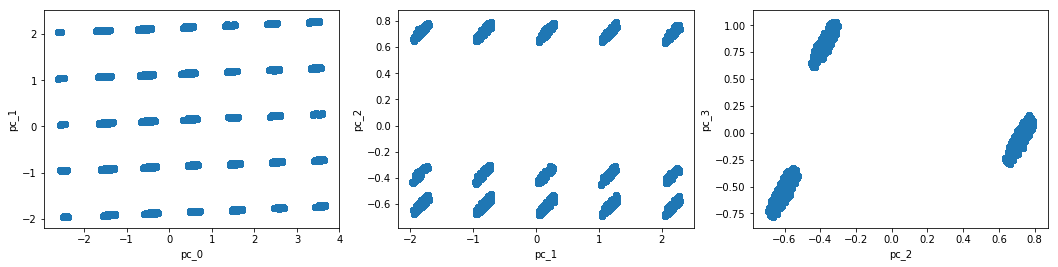

In [7]:
plot_pca(X_pca)

### K-means Clustering

#### Finding Optimal K

In [167]:
def run_elbow_method(X_frame, demo_cols, max_K = 10): # can change to PCA dataset
    kmeansdf = X_frame[demo_cols]
    distortions = []

    K = range(1, max_K + 1)
    for k in K:
        kmean = KMeans(n_clusters=k).fit(kmeansdf)
        distortions.append(sum(np.min(cdist(kmeansdf, kmean.cluster_centers_, 'euclidean'), axis=1)) / kmeansdf.shape[0])

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

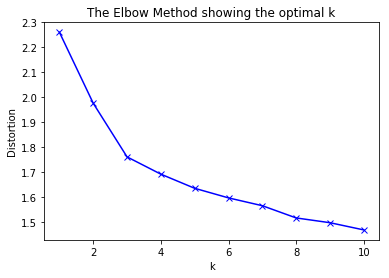

In [159]:
### DON'T RUN UNLESS YOU WANT TO FIND OPTIMAL K FOR K MEANS ###
### TAKES A LONG TIME TO RUN ###

# Model dataframe elbow method
run_elbow_method(X, demo_cols)

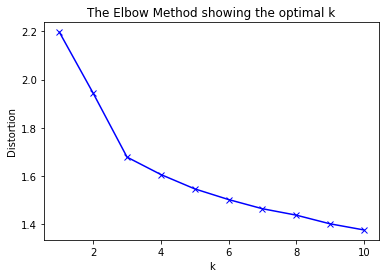

In [154]:
### DON'T RUN UNLESS YOU WANT TO FIND OPTIMAL K FOR K MEANS ###
### TAKES A LONG TIME TO RUN ###

#PCA elbow method
run_elbow_method(X_pca, pca_cols)

#### Clustering Dataset

In [4]:
# Generates k-means cluster datasets
# returns whole dataframe with clusters and cluster split dataframes
def create_cluster_modeldfs(X, y, demo_cols, isPCA = False, n_clusters = 3):
    kmeansdf = X[demo_cols]
    
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42).fit(kmeansdf) # testing shows that 2-3 clussters works the best
    cluster_nums = kmeans.predict(kmeansdf)

    # Single dataset for clusters
    X_cluster = pd.DataFrame(cluster_nums, columns = ['cluster_num'])
    X_cluster = X_cluster.join(X.drop(demo_cols, axis = 1))
        
    
    # Seperate datasets based on clusters
    temp = X_cluster.join(y)
    X_clusters = [temp[temp['cluster_num'] == x] for x in range(max(temp['cluster_num']) + 1)]
    X_clusters = [cluster.drop('cluster_num', axis = 1) for cluster in X_clusters]
    
    ranges = pd.unique(pd.Series(X_cluster["cluster_num"]))
    ranges.sort()
    mapped = ["cluster" + '_' + str(x) for x in ranges]
    X_cluster["cluster_num"] = X_cluster["cluster_num"].map(dict(zip(ranges, mapped)))
    one_hot = pd.get_dummies(X_cluster["cluster_num"])
    X_cluster = X_cluster.drop("cluster_num", axis = 1)
    X_cluster = pd.DataFrame(one_hot).join(X_cluster)
    
    return X_cluster, X_clusters

In [5]:
print("Clustering\n")

X_cluster, X_clusters = create_cluster_modeldfs(X, y, demo_cols)
X_cluster.head()

Clustering



cluster_0  cluster_1  cluster_2  p_cat_1_1  p_cat_1_10  p_cat_1_11  \
0          1          0          0          0           0           0   
1          1          0          0          1           0           0   
2          1          0          0          0           0           0   
3          1          0          0          0           0           0   
4          0          0          1          0           0           0   

   p_cat_1_12  p_cat_1_13  p_cat_1_14  p_cat_1_15    ...      p_cat_3_15  \
0           0           0           0           0    ...               0   
1           0           0           0           0    ...               0   
2           1           0           0           0    ...               0   
3           1           0           0           0    ...               0   
4           0           0           0           0    ...               0   

   p_cat_3_16  p_cat_3_17  p_cat_3_18  p_cat_3_3  p_cat_3_4  p_cat_3_5  \
0           0           0           0          0          0          0   
1           0           0           0          0          0          0   
2           0           0           0          0          0          0   
3           0           0           0          0          0          0   
4           0           0           0          0          0          0   

   p_cat_3_6  p_cat_3_8  p_cat_3_9  
0          0          0          0  
1          0          0          0  
2          0          0          0  
3          0          0          0  
4          0          0          0  

[5 rows x 53 columns]

In [11]:
print("Clustering Using PCAs\n")
# using k = 3 leads to the same dataset as clustering using modeling dataset

X_pca_cluster, X_pca_clusters = create_cluster_modeldfs(X_pca, y, pca_cols, isPCA = True)
X_pca_cluster.head()

Clustering Using PCAs



cluster_0  cluster_1  cluster_2  p_cat_1_1  p_cat_1_10  p_cat_1_11  \
0          1          0          0          0           0           0   
1          1          0          0          1           0           0   
2          1          0          0          0           0           0   
3          1          0          0          0           0           0   
4          0          0          1          0           0           0   

   p_cat_1_12  p_cat_1_13  p_cat_1_14  p_cat_1_15    ...      p_cat_3_15  \
0           0           0           0           0    ...               0   
1           0           0           0           0    ...               0   
2           1           0           0           0    ...               0   
3           1           0           0           0    ...               0   
4           0           0           0           0    ...               0   

   p_cat_3_16  p_cat_3_17  p_cat_3_18  p_cat_3_3  p_cat_3_4  p_cat_3_5  \
0           0           0           0          0          0          0   
1           0           0           0          0          0          0   
2           0           0           0          0          0          0   
3           0           0           0          0          0          0   
4           0           0           0          0          0          0   

   p_cat_3_6  p_cat_3_8  p_cat_3_9  
0          0          0          0  
1          0          0          0  
2          0          0          0  
3          0          0          0  
4          0          0          0  

[5 rows x 53 columns]

#### Writing Cluster Results

In [60]:
# uses the minimal_preprocess dataset
def write_cluster_dataset(X_cluster):
    min_df = pd.read_csv("inputs/minimal_preprocess.csv")
    min_demo = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
    start = pd.DataFrame(min_df['u_id']).join(min_df['p_id'])
    some = ['p_cat_1','p_cat_2','p_cat_3']
    outcluster = start.join(pd.DataFrame(X_cluster['cluster_num'])).join(min_df[some]).join(min_df['pur'])
    outcluster.to_csv("inputs/user_clusters.csv", encoding='utf-8', index = False)
    return outcluster

In [61]:
outcluster = write_cluster_dataset(X_cluster)
outcluster.head()

u_id    p_id  cluster_num  p_cat_1  p_cat_2  p_cat_3    pur
0     1   69042            2        3        0        0   8370
1     1  248942            2        1        6       14  15200
2     1   87842            2       12        0        0   1422
3     1   85442            2       12       14        0   1057
4     2  285442            0        8        0        0   7969

# Predictive Modeling 

### Creating Modeling Datasets

In [50]:
# Train and testing data for model dataset
def split_model_data(X, y = y, scale = False): # can specify different
    if scale:
        X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=30)

    y_train = np.array(y_train).T.reshape(1, -1)[0]
    y_test = np.array(y_test).T.reshape(1, -1)[0]
    return X_train, X_test, y_train, y_test

In [51]:
def create_dataframe_split(X_data, y_data, scale = False):
    try:
        data_splits = (split_model_data(X_data, y_data, scale = scale))
        print("Dataframe shape:", data_splits[0].shape, data_splits[1].shape, data_splits[2].shape, data_splits[3].shape)      
        return data_splits[0], data_splits[1], data_splits[2], data_splits[3]
    except:
        print ("Create model dataframe first!")
        return [], [], [], []

In [52]:
print("Model Dataset")
X_train, X_test, y_train, y_test = create_dataframe_split(X, y)

print("\nModel Dataset Scaled")
X_s_train, X_s_test, y_s_train, y_s_test = create_dataframe_split(X, y, True)

print("\nPCA Dataset")
X_pca_train, X_pca_test, y_pca_train, y_pca_test = create_dataframe_split(X_pca, y)

print("\nPCA Dataset Scaled")
X_s_pca_train, X_s_pca_test, y_s_pca_train, y_s_pca_test = create_dataframe_split(X_pca, y, True)

print("\nCluster Dataset")
X_cl_train, X_cl_test, y_cl_train, y_cl_test = create_dataframe_split(X_cluster, y)

print("\nCluster Dataset Scaled")
X_s_cl_train, X_s_cl_test, y_s_cl_train, y_s_cl_test = create_dataframe_split(X_cluster, y, True)

print("\nPCA Cluster Dataset")
X_pca_cl_train, X_pca_cl_test, y_pca_cl_train, y_pca_cl_test = create_dataframe_split(X_pca_cluster, y) 

print("\nPCA Cluster Dataset Scaled")
X_s_pca_cl_train, X_s_pca_cl_test, y_s_pca_cl_train, y_s_pca_cl_test = create_dataframe_split(X_pca_cluster, y, True)

Model Dataset
Dataframe shape: (403182, 78) (134395, 78) (403182,) (134395,)

Model Dataset Scaled
Dataframe shape: (403182, 78) (134395, 78) (403182,) (134395,)

PCA Dataset
Dataframe shape: (403182, 64) (134395, 64) (403182,) (134395,)

PCA Dataset Scaled
Dataframe shape: (403182, 64) (134395, 64) (403182,) (134395,)

Cluster Dataset
Dataframe shape: (403182, 53) (134395, 53) (403182,) (134395,)

Cluster Dataset Scaled
Dataframe shape: (403182, 53) (134395, 53) (403182,) (134395,)

PCA Cluster Dataset
Dataframe shape: (403182, 53) (134395, 53) (403182,) (134395,)

PCA Cluster Dataset Scaled
Dataframe shape: (403182, 53) (134395, 53) (403182,) (134395,)


In [6]:
def create_cluster_dataframe_split(clusters):
    try:
        X_cl_trains = []
        X_cl_tests = [] 
        y_cl_trains = []
        y_cl_tests = []
        for i, clusterdf in enumerate(clusters):
            X_frame = clusterdf.drop(predictor, axis = 1)
            y_frame = clusterdf[predictor]
            X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_frame, y_frame, test_size = 0.25, random_state=30)
            y_cl_train = np.array(y_cl_train).T.reshape(1, -1)[0]
            y_cl_test = np.array(y_cl_test).T.reshape(1, -1)[0]
            X_cl_trains.append(X_cl_train)
            X_cl_tests.append(X_cl_test)
            y_cl_trains.append(y_cl_train)
            y_cl_tests.append(y_cl_test)
            print("Cluster num", i, ":" , X_cl_trains[i].shape, X_cl_tests[i].shape, y_cl_trains[i].shape, y_cl_tests[i].shape)
        print("")
        return X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests
    except:
        print ("Create model dataframe first!")
        print("")
        return [], [], [], []
    

In [12]:
print("Cluster Dataset")
X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests = create_cluster_dataframe_split(X_clusters)

print("\nPCA Cluster Dataset")
X_pca_cl_trains, X_pca_cl_tests, y_pca_cl_trains, y_pca_cl_tests = create_cluster_dataframe_split(X_pca_clusters)

Cluster Dataset
Cluster num 0 : (216855, 50) (72285, 50) (216855,) (72285,)
Cluster num 1 : (114307, 50) (38103, 50) (114307,) (38103,)
Cluster num 2 : (72020, 50) (24007, 50) (72020,) (24007,)


PCA Cluster Dataset
Cluster num 0 : (216855, 50) (72285, 50) (216855,) (72285,)
Cluster num 1 : (114307, 50) (38103, 50) (114307,) (38103,)
Cluster num 2 : (72020, 50) (24007, 50) (72020,) (24007,)



### Linear Regression

In [16]:
def linear_reg_data(X_tr, y_tr, X_te, y_te):
    reg = LinearRegression().fit(X_tr, y_tr)
    print("MAE for test set: ", mean_absolute_error(reg.predict(X_te), y_te))

In [17]:
print("Model Dataset")
linear_reg_data(X_train, y_train, X_test, y_test)

print("\nModel Dataset Scaled")
linear_reg_data(X_s_train, y_s_train, X_s_test, y_s_test)

print("\nPCA Dataset")
linear_reg_data(X_pca_train, y_pca_train, X_pca_test, y_pca_test)

print("\nPCA Dataset Scaled")
linear_reg_data(X_s_pca_train, y_s_pca_train, X_s_pca_test, y_s_pca_test)

print("\nCluster Dataset")
linear_reg_data(X_cl_train, y_cl_train, X_cl_test, y_cl_test)

print("\nCluster Dataset Scaled")
linear_reg_data(X_s_cl_train, y_s_cl_train, X_s_cl_test, y_s_cl_test)

print("\nPCA Cluster Dataset")
linear_reg_data(X_pca_cl_train, y_pca_cl_train, X_pca_cl_test, y_pca_cl_test)

print("\nPCA Cluster Dataset Scaled")
linear_reg_data(X_s_pca_cl_train, y_s_pca_cl_train, X_s_pca_cl_test, y_s_pca_cl_test)

Model Dataset
MAE for test set:  2262.834284199561

Model Dataset Scaled
MAE for test set:  2262.7781160058903

PCA Dataset
MAE for test set:  2263.9201089256485

PCA Dataset Scaled
MAE for test set:  2263.8227125525104

Cluster Dataset
MAE for test set:  2274.7966343962757

Cluster Dataset Scaled
MAE for test set:  2274.90475881264

PCA Cluster Dataset
MAE for test set:  2274.7966343962757

PCA Cluster Dataset Scaled
MAE for test set:  2274.90475881264


In [18]:
print("Cluster Dataset\n-------------")

for i, X_cl_tr, X_cl_te, y_cl_tr, y_cl_te in zip(range(len(X_cl_trains)), X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests):
    print("Cluster num:", i)
    linear_reg_data(X_cl_tr, y_cl_tr, X_cl_te, y_cl_te)
    print("")

Cluster Dataset
-------------
Cluster num: 0
MAE for test set:  2318.5665093034518

Cluster num: 1
MAE for test set:  2304.8060946644623

Cluster num: 2
MAE for test set:  2098.163462740034



In [19]:
print("PCA Cluster Dataset\n-------------")

for i, X_cl_tr, X_cl_te, y_cl_tr, y_cl_te in zip(range(len(X_pca_cl_trains)), X_pca_cl_trains, X_pca_cl_tests, y_pca_cl_trains, y_pca_cl_tests):
    print("Cluster num:", i)
    linear_reg_data(X_cl_tr, y_cl_tr, X_cl_te, y_cl_te)
    print("")

PCA Cluster Dataset
-------------
Cluster num: 0
MAE for test set:  2318.5665093034518

Cluster num: 1
MAE for test set:  2304.8060946644623

Cluster num: 2
MAE for test set:  2098.163462740034



### MLP Regression

In [20]:
def MLP_data(X_tr, y_tr, X_te, y_te, verbose = False):  
    mlp = MLPRegressor(activation = 'identity',
                   hidden_layer_sizes = (25, 1),
                   solver = 'adam',
                   learning_rate = 'constant',
                   random_state = 42,
                   batch_size = 3000,
                   verbose = verbose,
                   learning_rate_init = 1).fit(X_tr, y_tr)
    plt.plot(np.sqrt(mlp.loss_curve_))
    plt.xlabel("epoch")
    plt.ylabel("MAE")
    print("MAE for test set: ", mean_absolute_error(mlp.predict(X_te), y_te))
    plt.show()
    return mlp

Model Dataset
MAE for test set:  2269.339326365205


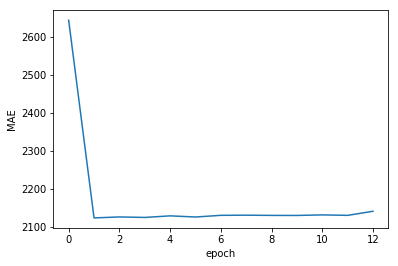


Model Dataset Scaled
MAE for test set:  2269.4266873555894


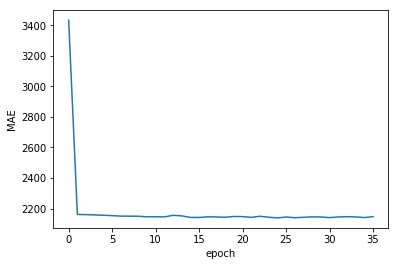


PCA Dataset
MAE for test set:  2293.5680163040347


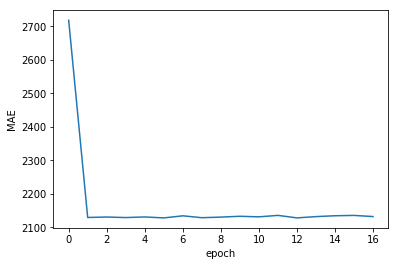


PCA Dataset Scaled
MAE for test set:  2254.3890065201613


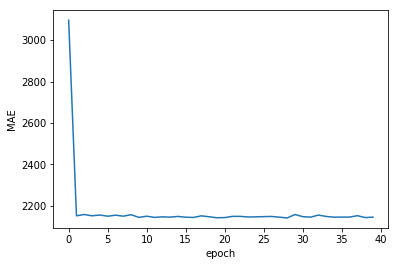


Cluster Dataset
MAE for test set:  2298.115499668723


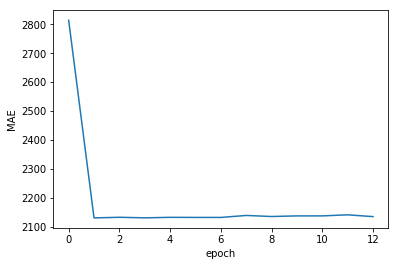


Cluster Dataset Scaled
MAE for test set:  2315.147098460789


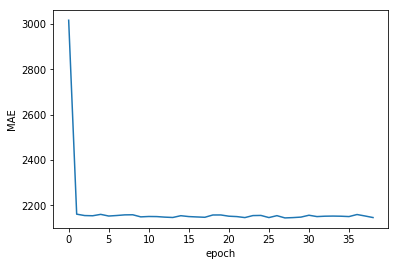


PCA Cluster Dataset
MAE for test set:  2298.115499668723


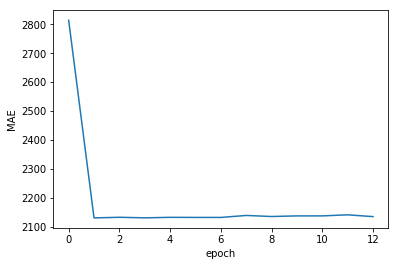


PCA Cluster Dataset Scaled
MAE for test set:  2315.147098460789


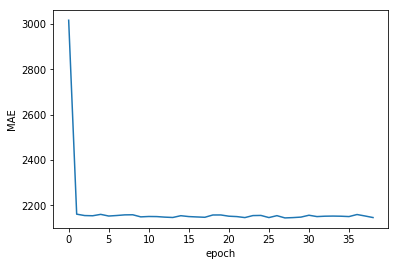

In [21]:
print("Model Dataset")
_ = MLP_data(X_train, y_train, X_test, y_test)

print("\nModel Dataset Scaled")
_ = MLP_data(X_s_train, y_s_train, X_s_test, y_s_test)

print("\nPCA Dataset")
_ = MLP_data(X_pca_train, y_pca_train, X_pca_test, y_pca_test)

print("\nPCA Dataset Scaled")
_ = MLP_data(X_s_pca_train, y_s_pca_train, X_s_pca_test, y_s_pca_test)

print("\nCluster Dataset")
_ = MLP_data(X_cl_train, y_cl_train, X_cl_test, y_cl_test)

print("\nCluster Dataset Scaled")
_ = MLP_data(X_s_cl_train, y_s_cl_train, X_s_cl_test, y_s_cl_test)

print("\nPCA Cluster Dataset")
_ = MLP_data(X_pca_cl_train, y_pca_cl_train, X_pca_cl_test, y_pca_cl_test)

print("\nPCA Cluster Dataset Scaled")
_ = MLP_data(X_s_pca_cl_train, y_s_pca_cl_train, X_s_pca_cl_test, y_s_pca_cl_test)

Cluster Dataset
-------------
Cluster num: 0
MAE for test set:  2332.650269759691


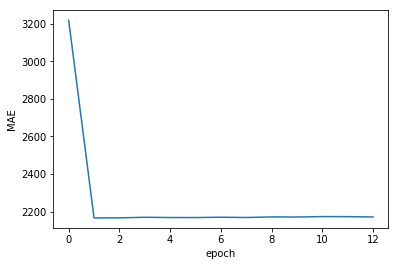

Cluster num: 1
MAE for test set:  2336.9611128807305


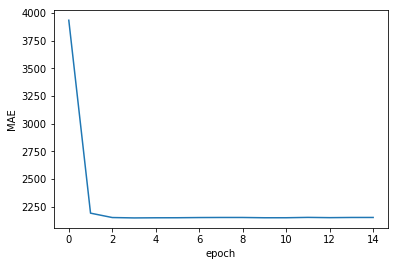

Cluster num: 2
MAE for test set:  2186.625892691395


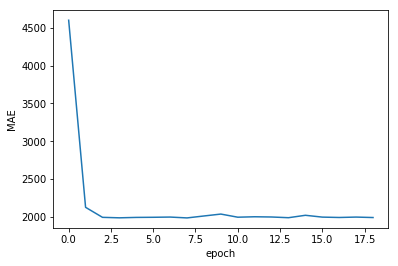

In [22]:
print("Cluster Dataset\n-------------")

for i, X_cl_tr, X_cl_te, y_cl_tr, y_cl_te in zip(range(len(X_cl_trains)), X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests):
    print("Cluster num:", i)
    _ = MLP_data(X_cl_tr, y_cl_tr, X_cl_te, y_cl_te, verbose = False)

PCA Cluster Dataset
-------------
Cluster num: 0
MAE for test set:  2332.650269759691


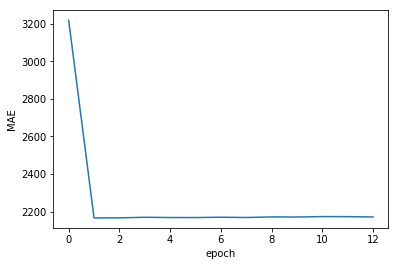

Cluster num: 1
MAE for test set:  2336.9611128807305


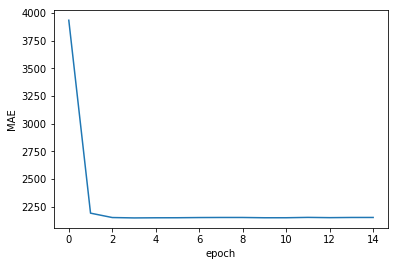

Cluster num: 2
MAE for test set:  2186.625892691395


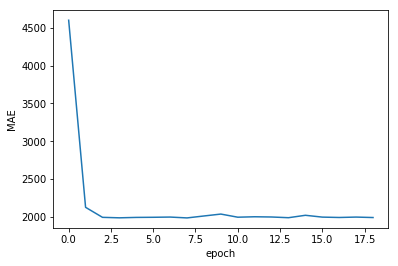

In [23]:
print("PCA Cluster Dataset\n-------------")

for i, X_cl_tr, X_cl_te, y_cl_tr, y_cl_te in zip(range(len(X_pca_cl_trains)), X_pca_cl_trains, X_pca_cl_tests, y_pca_cl_trains, y_pca_cl_tests):
    print("Cluster num:", i)
    _ = MLP_data(X_cl_tr, y_cl_tr, X_cl_te, y_cl_te, verbose = False)

In [154]:
learning_rates = [1.5]
for learning_rate in learning_rates:
    gb = GradientBoostingRegressor(learning_rate = learning_rate, random_state = 42, max_leaf_nodes = 300, verbose = 2).fit(X_s_train, y_s_train)
    print(mean_absolute_error(gb.predict(X_s_test), y_s_test))

      Iter       Train Loss   Remaining Time 
         1    14903462.7803            6.80m
         2    12279254.4287            6.64m
         3    10831559.4734            6.36m
         4     9602867.1297            6.33m
         5     9238789.8071            6.30m
         6     9033389.8721            6.03m
         7     8894627.0665            5.85m
         8     8796549.7623            5.72m
         9     8750142.9368            5.62m
        10     8652795.6606            5.65m
        11     8608613.7233            5.58m
        12     8580452.0148            5.48m
        13     8563831.9300            5.36m
        14     8547366.7099            5.27m
        15     8533301.5130            5.20m
        16     8521389.7093            5.13m
        17     8509538.8077            5.03m
        18     8486961.0245            4.96m
        19     8469192.5903            4.88m
        20     8453594.3664            4.86m
        21     8442460.7919            4.81m
        2

In [57]:
def xgboost_data(X_tr, y_tr, X_te, y_te):
    param = {
        'eta': .9,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'eval_metric': 'mae',
        'grow_policy' : 'depthwise',
        'tree_method' : 'hist',
        'max_depth' : 10,
        'seed': 42}
    num_round = 20  # the number of training iterations
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dtest = xgb.DMatrix(X_te, label=y_te)

    bst = xgb.train(param, dtrain, num_round)
    print("MAE: ", mean_absolute_error(bst.predict(dtest), y_te))
    return bst

In [58]:
print("Model Dataset")
_ = xgboost_data(X_train, y_train, X_test, y_test)

print("\nModel Dataset Scaled")
_ = xgboost_data(X_s_train, y_s_train, X_s_test, y_s_test)

print("\nPCA Dataset")
_ = xgboost_data(X_pca_train, y_pca_train, X_pca_test, y_pca_test)

print("\nPCA Dataset Scaled")
_ = xgboost_data(X_s_pca_train, y_s_pca_train, X_s_pca_test, y_s_pca_test)

print("\nCluster Dataset")
_ = xgboost_data(X_cl_train, y_cl_train, X_cl_test, y_cl_test)

print("\nCluster Dataset Scaled")
_ = xgboost_data(X_s_cl_train, y_s_cl_train, X_s_cl_test, y_s_cl_test)

print("\nPCA Cluster Dataset")
_ = xgboost_data(X_pca_cl_train, y_pca_cl_train, X_pca_cl_test, y_pca_cl_test)

print("\nPCA Cluster Dataset Scaled")
_ = xgboost_data(X_s_pca_cl_train, y_s_pca_cl_train, X_s_pca_cl_test, y_s_pca_cl_test)

Model Dataset
[03:14:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2164.1833295798797

Model Dataset Scaled
[03:14:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2164.1833295798797

PCA Dataset
[03:14:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2152.6096465851856

PCA Dataset Scaled
[03:14:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2147.928267611412

Cluster Dataset
[03:14:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2216.9480517280203

Cluster Dataset Scaled
[03:14:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2216.9480517280203

PCA Cluster Dataset
[03:14:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2216.9480517280203

PCA Clus

In [55]:
def xgboost_cluster_data(X_cl_trs, X_cl_tes, y_cl_trs, y_cl_tes):
    param = {
        'eta': 0.5,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'eval_metric': 'mae',
        'grow_policy' : 'depthwise',
        'tree_method' : 'hist',
        'max_depth' : 18,
        'seed': 42}
    bsts = []
    num_round = 20  # the number of training iterations
    mean_mae = 0

    for i, X_cl_tr, X_cl_te, y_cl_tr, y_cl_te in zip(range(len(X_cl_trs)), X_cl_trs, X_cl_tes, y_cl_trs, y_cl_tes):
        dtrain = xgb.DMatrix(X_cl_tr, label=y_cl_tr)
        dtest = xgb.DMatrix(X_cl_te, label=y_cl_te)

        bst = xgb.train(param, dtrain, num_round)
        temp_mae = mean_absolute_error(bst.predict(dtest), y_cl_te)
        mean_mae = mean_mae + temp_mae
        print("MAE for cluster", i, ":", temp_mae)
        print("")
        bsts.append(bst)
    print("\nAverage MAE for all clusters:", mean_mae/len(X_cl_trs))
    return bsts

In [16]:
bsts = xgboost_cluster_data(X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests)

[02:58:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE for cluster 0 : 2257.259213202163

[02:58:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE for cluster 1 : 2248.000381426877

[02:58:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE for cluster 2 : 2040.2303268337914


Average MAE for all clusters: 2181.829973820944


In [56]:
bsts = xgboost_cluster_data(X_pca_cl_trains, X_pca_cl_tests, y_pca_cl_trains, y_pca_cl_tests)

[03:14:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE for cluster 0 : 2257.2289464478376

[03:14:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE for cluster 1 : 2247.91194189234

[03:14:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE for cluster 2 : 2040.108892912012


Average MAE for all clusters: 2181.7499270840635


[02:50:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2164.1833295798797


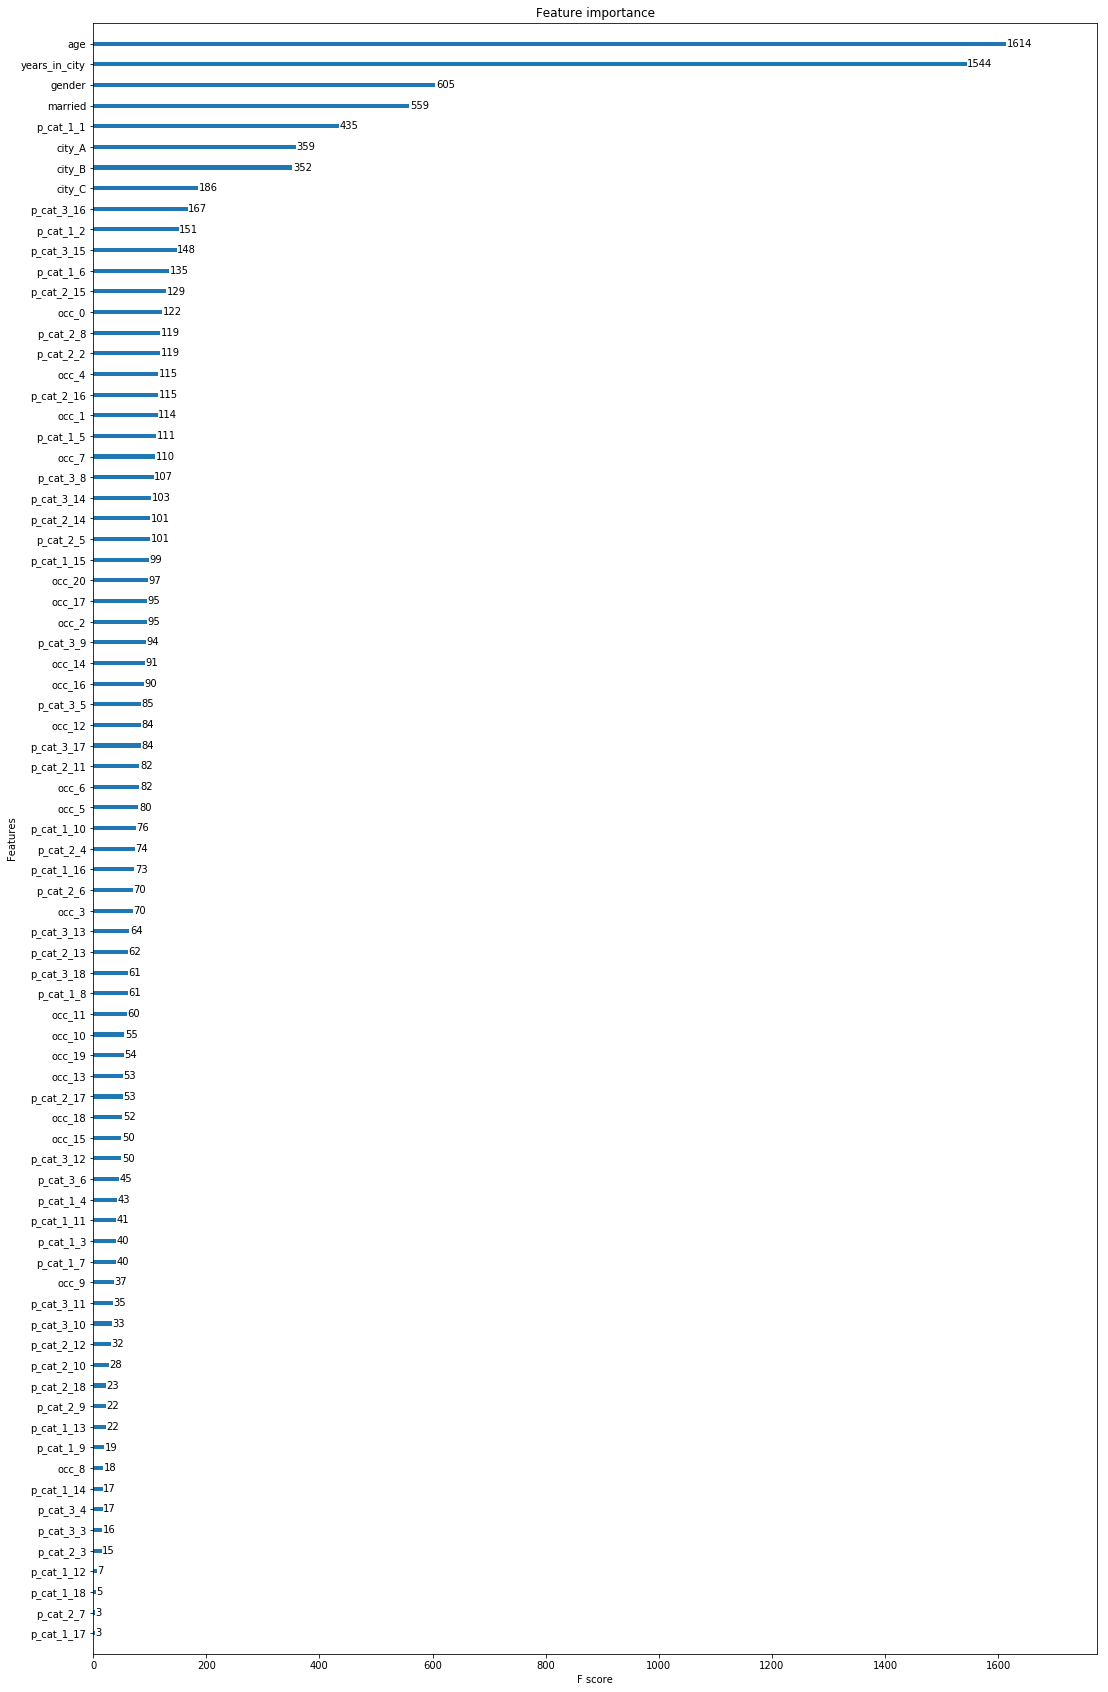

In [29]:
fig, axes = plt.subplots(1, 1, figsize = (18,30))
bst = xgboost_data(X_train, y_train, X_test, y_test)
xgb.plot_importance(bst, ax = axes, grid = False)

In [18]:
def plot_residuals(bst, X_tr, y_tr):
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    
    predictions_train = bst.predict(dtrain)
    residuals = y_tr - predictions_train

    fig = plt.figure(figsize=(12,4))

    ax1 = fig.add_subplot(121)
    ax1.scatter(predictions_train, residuals)
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Residual")

    ax2 = fig.add_subplot(122)
    ax2.hist(residuals)
    ax2.set_xlabel("Residual")
    ax2.set_ylabel("Frequency")

[03:17:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE:  2147.928267611412


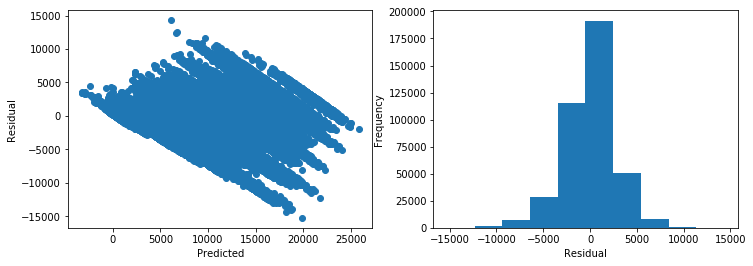

In [64]:
bst = xgboost_data(X_s_pca_train, y_s_pca_train, X_s_pca_test, y_s_pca_test)
plot_residuals(bst, X_s_pca_train, y_s_pca_train)

[02:59:14] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE for cluster 0 : 2257.259213202163

[02:59:16] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE for cluster 1 : 2248.000381426877

[02:59:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
MAE for cluster 2 : 2040.2303268337914


Average MAE for all clusters: 2181.829973820944


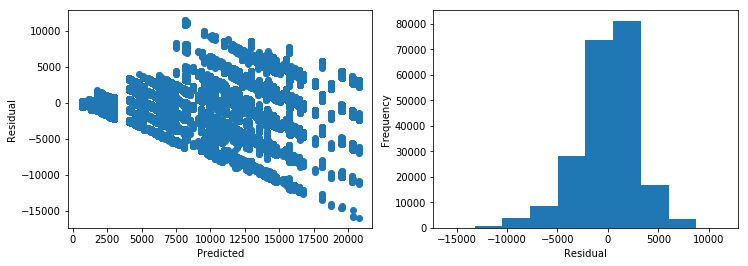

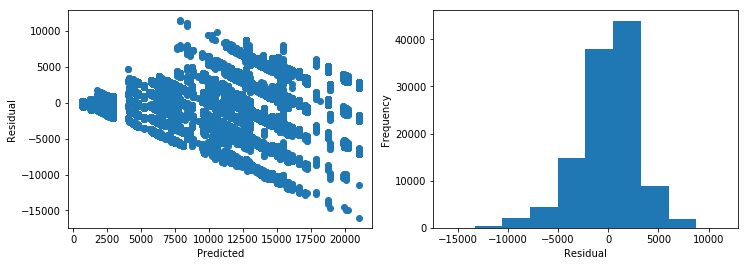

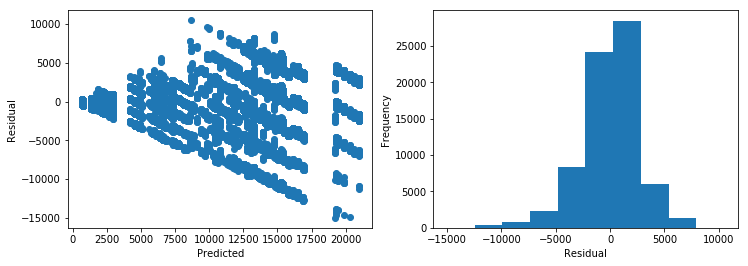

In [19]:
bsts = xgboost_cluster_data(X_cl_trains, X_cl_tests, y_cl_trains, y_cl_tests)
for i, bst, X_cl_tr, y_cl_tr in zip(range(len(bsts)), bsts, X_cl_trains, y_cl_trains):
    plot_residuals(bst, X_cl_tr, y_cl_tr)